# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score ,cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

# magic word for producing visualizations in notebook
%matplotlib inline

C:\Users\Nermin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [180]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias.shape

(891221, 366)

In [8]:
customer.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0


In [9]:
customer.shape

(191652, 369)

In [10]:
#reading information levels
#dias_information_levels=pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx',sep=';')
dias_information_levels=pd.read_csv('Information Levels_2017.csv',encoding='latin1')
dias_information_levels.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [11]:
dias_information_levels.shape

(313, 4)

In [12]:
#reading attribute values
#dias_attribute_values=pd.read_excel('./DIAS Attributes - Values 2017.xlsx',sep=';')
dias_attribute_values=pd.read_csv('Attributes_Values_2017.csv',encoding='latin1')
dias_attribute_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [13]:
dias_attribute_values.shape

(2258, 4)

Lets check how many unique attributes in attribute data sets actuallly exist in customer and azdias data frames

In [14]:
azdias_columns=set(azdias.columns)
customer_columns=set(customer.columns)
attribute_names=set(dias_attribute_values['Attribute'])
information_levelt=set(dias_information_levels['Attribute'])

In [10]:
note1= 'The number of common columns with attribute levels and \n Azdias is {} \n Customer is {} '.format(len(attribute_names.intersection(azdias_columns))
                                                                                                          ,len(attribute_names.intersection(customer_columns)))
note2= 'The number of common columns with information levels and \n Azdias is {} \n Customer is {} '.format(len(information_levelt.intersection(azdias_columns))
                                                                                                          ,len(information_levelt.intersection(customer_columns)))

print(note1)
print(note2)

The number of common columns with attribute levels and 
 Azdias is 272 
 Customer is 272 
The number of common columns with information levels and 
 Azdias is 264 
 Customer is 264 


In [16]:
#lets check whether these columns are same in customer and azdias data sets
information_levelt.intersection(azdias_columns)==information_levelt.intersection(customer_columns)

True

In [22]:
#lets check whether these columns are same in customer and azdias data sets
attribute_names.intersection(azdias_columns)==attribute_names.intersection(customer_columns)

True

In [18]:
len(information_levelt.intersection(customer_columns).intersection(attribute_names.intersection(customer_columns)))

260

In [19]:
len(information_levelt.intersection(azdias_columns).intersection(attribute_names.intersection(azdias_columns)))

260

There are 4 coulumns in information level attributes and customer/azdias data have in common but they are not in the attribute data set. Lets see which columns are they

In [20]:
information_levelt.intersection(customer_columns).difference(attribute_names.intersection(customer_columns))

{'ARBEIT',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM'}

In [21]:
dias_information_levels.loc[(dias_information_levels['Attribute']=='ARBEIT')|
                            (dias_information_levels['Attribute']=='D19_VERSI_DATUM')|
                            (dias_information_levels['Attribute']=='D19_VERSI_OFFLINE_DATUM')|
                            (dias_information_levels['Attribute']=='D19_VERSI_ONLINE_DATUM')
                           ]

,Information level,Attribute,Description,Additional notes
67,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN
308,Community,ARBEIT,share of unemployed person in the community,NaN


In [22]:
#To see the ful sentence in description column
dias_information_levels.loc[(dias_information_levels['Attribute']=='ARBEIT')|
                            (dias_information_levels['Attribute']=='D19_VERSI_DATUM')|
                            (dias_information_levels['Attribute']=='D19_VERSI_OFFLINE_DATUM')|
                            (dias_information_levels['Attribute']=='D19_VERSI_ONLINE_DATUM'),'Description'
                           ].values

array(['actuality of the last transaction for the segment insurance OFFLINE',
       'actuality of the last transaction for the segment insurance ONLINE',
       'actuality of the last transaction for the segment insurance TOTAL',
       'share of unemployed person in the community'], dtype=object)

In [23]:
#Lest see how these clolumns are seen in the actual data set
customer[['ARBEIT','D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM']].head()

,ARBEIT,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM
0,1.0,10,10,10
1,NaN,10,10,10
2,3.0,10,10,10
3,1.0,9,10,10
4,3.0,10,10,10


In [20]:
customer[['ARBEIT','D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM']].describe()

,ARBEIT,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM
count,141176.000000,191652.000000,191652.000000,191652.000000
mean,2.824850,9.209171,9.917298,9.983162
std,1.012415,1.856680,0.563425,0.261332
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,10.000000,10.000000,10.000000
50%,3.000000,10.000000,10.000000,10.000000
75%,4.000000,10.000000,10.000000,10.000000
max,9.000000,10.000000,10.000000,10.000000


In [21]:
unique_elements, counts_elements = np.unique(customer['ARBEIT'], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[1.0000e+00 2.0000e+00 3.0000e+00 ...        nan        nan        nan]
 [1.6941e+04 3.3334e+04 5.0905e+04 ... 1.0000e+00 1.0000e+00 1.0000e+00]]


In [22]:
unique_elements, counts_elements = np.unique(customer['D19_VERSI_DATUM'], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[     1      2      3      4      5      6      7      8      9     10]
 [  1691   3165   1297   1771   6492   4740   3664   6834  15240 146758]]


In [23]:
unique_elements, counts_elements = np.unique(customer['D19_VERSI_OFFLINE_DATUM'], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[     1      2      3      4      5      6      7      8      9     10]
 [    10     24     16     37   1723    365    197   1216   2136 185928]]


In [24]:
unique_elements, counts_elements = np.unique(customer['D19_VERSI_ONLINE_DATUM'], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[     1      2      3      4      5      6      7      8      9     10]
 [    13     12     19     49    165    107    172    212    394 190509]]


We have information about 272 columns in the data sets. Even though we have 4 more variable in information data set, we do not have any information regarding the meanings of the value codes. When we look at the frequency of unique values 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM' variables tends to have a value of 10. In general the std values also seem small.It is better to drop these columns with remaining columns as we do not know what they are about and/or they do not provide much information.

In [15]:
attribute_names=set(dias_attribute_values['Attribute'])
azdias_columns=set(azdias.columns)
columns_to_be_kept= list(attribute_names.intersection(azdias_columns).union(set(['LNR']))) #adding LNR id column
#columns_to_be_kept[0:10]
len(columns_to_be_kept)

273

## Cleaning the data sets
We sucessfully read the data files. However the column names of the customer and adias data do not seem explicitly defined. To be able to understand the data, first we need to understand the description files. 

In [12]:
#Understand the attribute values
null_attributes=dias_attribute_values['Attribute'].isnull().sum()
print('there are {} missing value in attribute column '.format(null_attributes))

there are 1944 missing value in attribute column 


In [31]:
#Have a better look to attribute data
dias_attribute_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


Attribute data shows that the NaN values in attributes are categoriews of the previous attribute. W e can forward fill the NaNs to have a better look of the data.

In [16]:
dias_attribute_values['Attribute']=dias_attribute_values['Attribute'].ffill()
dias_attribute_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [33]:
#Lets take a look at the meanings of the some values in the data
dias_attribute_values['Meaning'].value_counts().head(13)

unknown                            232
average                            162
low                                154
high                               154
very high                          142
very low                           139
none                               138
Singlebuyer 0-12 months             34
Multibuyer 0-12 months              34
Multi-/Doublebuyer 13-24 months     34
Buyer > 24 months                   34
Doublebuyer 0-12 months             34
Singlebuyer 13-24 months            34
Name: Meaning, dtype: int64

The code above shows us some of the values in the data set represent unknown values. We should change these values as NaNs as we don't know their meanings

In [17]:
unknown_attributes=dias_attribute_values.loc[(dias_attribute_values['Meaning']=='unknown')|
                                             (dias_attribute_values['Meaning']=='unknown / no main age detectable')|
                                             (dias_attribute_values['Meaning']=='no transaction known')|
                                             (dias_attribute_values['Meaning']=='no transactions known')|
                                             (dias_attribute_values['Meaning']=='none')
                                            ]
unknown_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [18]:
unknown_attributes.shape

(427, 4)

#### Missing Data

In [19]:
def recode_missing(df1,df2=unknown_attributes):
    """Replace missing value codes defined in df2 to numpy nan values
    INPUT:
    df1: data frame we woluld like to replace missing values
    df2: data frame including nan and unkown codigns
    
    OUTPUT:
    df1: data frame unkown and missing value codes replaced as numpy nans. 
    """
    for column in df1.columns:
        if column in list(df2['Attribute']):
            na_values=df2.loc[df2['Attribute']==column,'Value'].iloc[0]
            value = str(na_values)
            list_value = list(map(int,value.split(',')))
            df1.loc[df1.loc[:, column].isin(list_value), column] = np.nan
    return df1
    

In [221]:
azdias_recoded=recode_missing(azdias)

In [155]:
azdias_recoded.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [156]:
customer_recoded=recode_missing(customer)

In [157]:
customer_recoded.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0


##### Graphics: Column wise

In [39]:
count_nan_azdias = azdias_recoded.isnull().sum()/len(azdias_recoded)

count_nan_customer = customer_recoded.isnull().sum()/len(customer_recoded)

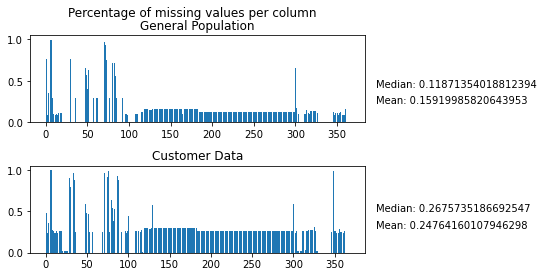

In [40]:
fig, axs = plt.subplots(2)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Percentage of missing values per column')
axs[0].bar(range(len(count_nan_azdias.values)),count_nan_azdias.values)
axs[1].bar(range(len(count_nan_customer.values)),count_nan_customer.values)

axs[1].set_title('Customer Data')
axs[0].set_title('General Population')

plt.text(400, 2, s='Median: {}'.format(count_nan_azdias.median()))
plt.text(400, 1.8, s='Mean: {}'.format(count_nan_azdias.mean()))

plt.text(400, 0.5, s='Median: {}'.format(count_nan_customer.median()))
plt.text(400, 0.3, s='Mean: {}'.format(count_nan_customer.mean()))
plt.show()

The graphs above shouw that the average missing value for customer data is araoun 27 %. However, there ara columns having more han 50 percent missing value. Later we will delete the columns having more than 30% missing value

##### Graphics: Row wise

In [24]:
row_nan_azdias = azdias_recoded.isnull().sum(axis=1)/len(azdias_recoded.columns)
row_nan_customer = customer_recoded.isnull().sum(axis=1)/len(customer_recoded.columns)
sorted_row_azdias=np.sort(row_nan_azdias.values)[::-1]
sorted_row_customer=np.sort(row_nan_customer.values)[::-1]

Text(300000, 0.4, 'Mean: 0.248')

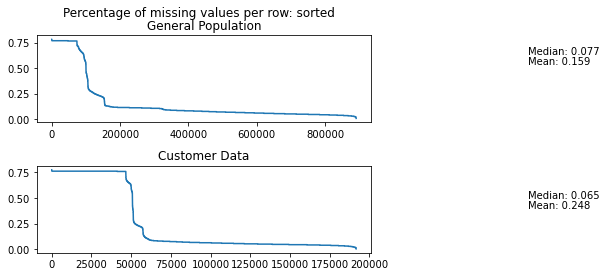

In [26]:
fig, axs = plt.subplots(2)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Percentage of missing values per row: sorted')
axs[0].plot(sorted_row_azdias)
axs[1].plot(sorted_row_customer)

axs[1].set_title('Customer Data')
axs[0].set_title('General Population')

plt.text(300000, 1.9, s='Median: {}'.format(np.median(sorted_row_azdias).round(3)))
plt.text(300000, 1.8, s='Mean: {}'.format(np.mean(sorted_row_azdias).round(3)))

plt.text(300000, 0.5, s='Median: {}'.format(np.median(sorted_row_customer).round(3)))
plt.text(300000, 0.4, s='Mean: {}'.format(np.mean(sorted_row_customer).round(3)))


The graphs above show that the average missing value for customer data is araoun 25 %. However, there ara rows having more than 70 percent missing value. Later we will delete the rows having more than 30% missing value. We can also see that the median values for both general population and customer population is lover then 1 %. After deleting extereme rows, we can impute missing values.

### Understanding the variables:

#### Column selection
Before going further in data wrangling, I selected the columns only we have information about them

In [41]:
azdias_v1=azdias_recoded[columns_to_be_kept]
azdias_v1.head()

,KBA05_MAXHERST,KBA05_SEG5,D19_KONSUMTYP,KBA05_BAUMAX,D19_GESAMT_OFFLINE_DATUM,KBA05_KRSHERST3,KBA13_VORB_3,KBA05_KW2,KBA13_KW_90,D19_TELKO_OFFLINE_DATUM,...,KBA05_ZUL4,KBA13_ALTERHALTER_45,NATIONALITAET_KZ,KBA05_VORB1,KBA05_ALTER3,PLZ8_GBZ,D19_GESAMT_ONLINE_DATUM,D19_BANKEN_ANZ_12,KBA13_KMH_211,KBA13_SEG_KOMPAKTKLASSE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2.0,NaN,5.0,NaN,2.0,3.0,3.0,3.0,NaN,...,2.0,2.0,1.0,1.0,1.0,4.0,NaN,NaN,3.0,5.0
2,5.0,1.0,9.0,NaN,NaN,3.0,2.0,2.0,2.0,NaN,...,4.0,2.0,1.0,2.0,3.0,4.0,NaN,NaN,4.0,1.0
3,3.0,2.0,9.0,1.0,NaN,3.0,2.0,4.0,3.0,NaN,...,3.0,3.0,1.0,5.0,3.0,4.0,NaN,NaN,5.0,4.0
4,3.0,2.0,1.0,NaN,6.0,3.0,4.0,2.0,3.0,8.0,...,2.0,3.0,1.0,1.0,4.0,3.0,1.0,3.0,5.0,3.0


In [42]:
customer_v1=customer_recoded[columns_to_be_kept]
customer_v1.head()

,KBA05_MAXHERST,KBA05_SEG5,D19_KONSUMTYP,KBA05_BAUMAX,D19_GESAMT_OFFLINE_DATUM,KBA05_KRSHERST3,KBA13_VORB_3,KBA05_KW2,KBA13_KW_90,D19_TELKO_OFFLINE_DATUM,...,KBA05_ZUL4,KBA13_ALTERHALTER_45,NATIONALITAET_KZ,KBA05_VORB1,KBA05_ALTER3,PLZ8_GBZ,D19_GESAMT_ONLINE_DATUM,D19_BANKEN_ANZ_12,KBA13_KMH_211,KBA13_SEG_KOMPAKTKLASSE
0,2.0,3.0,3.0,NaN,9.0,3.0,1.0,3.0,3.0,NaN,...,3.0,2.0,1.0,3.0,4.0,5.0,NaN,NaN,3.0,3.0
1,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN
2,2.0,1.0,3.0,NaN,NaN,2.0,4.0,3.0,0.0,NaN,...,2.0,3.0,1.0,3.0,2.0,2.0,NaN,NaN,3.0,3.0
3,4.0,0.0,3.0,1.0,6.0,2.0,3.0,4.0,2.0,NaN,...,4.0,4.0,1.0,3.0,3.0,4.0,NaN,NaN,3.0,3.0
4,2.0,1.0,1.0,NaN,8.0,3.0,0.0,4.0,3.0,NaN,...,1.0,3.0,1.0,4.0,4.0,3.0,1.0,1.0,3.0,3.0


#### Data type checking

Before going further with cleaning it is a good practice to take a look at the data types. Machine lerning models don't work with onject data types. In the following section I selected the columns that are object and examine those columns

In [41]:
a=azdias_v1.dtypes.values

unique_elements, counts_elements = np.unique(a, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[dtype('int64') dtype('float64') dtype('O')]
 [2 267 3]]


In [42]:
b=customer_v1.dtypes.values

unique_elements, counts_elements = np.unique(b, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[dtype('int64') dtype('float64') dtype('O')]
 [2 267 3]]


##### Object data type columns

There are 6 columns in the azdias and 8 columns in customer data set whose type is object. The remining columns are numreic. Lets check these columns first. 

In [43]:
azdias_v1.loc[:,azdias_v1.dtypes=='object'].head()

,OST_WEST_KZ,CAMEO_DEU_2015,CAMEO_DEUG_2015
0,NaN,NaN,NaN
1,W,8A,8
2,W,4C,4
3,W,2A,2
4,W,6B,6


To have a clear understanding I looked at the attribute data.

In [231]:
dias_attribute_values.loc[(dias_attribute_values['Attribute']=='CAMEO_DEU_2015')|
                            (dias_attribute_values['Attribute']=='CAMEO_DEUG_2015')|
                            (dias_attribute_values['Attribute']=='OST_WEST_KZ')
                         ]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


##### Integer data types

In [232]:
azdias_v1.loc[:,azdias_v1.dtypes=='int64'].head()

,GEBURTSJAHR,GREEN_AVANTGARDE
0,0,0
1,1996,0
2,1979,1
3,1957,0
4,1963,0


In [233]:
dias_attribute_values.loc[(dias_attribute_values['Attribute']=='GEBURTSJAHR')|
                          (dias_attribute_values['Attribute']=='GREEN_AVANTGARDE')]

,Attribute,Description,Value,Meaning
711,GEBURTSJAHR,year of birth,,numeric value
732,GREEN_AVANTGARDE,Green avantgarde,0,doesn't belong to the green avantgarde
733,GREEN_AVANTGARDE,the environmental sustainability is the domina...,1,belongs to the green avantgarde


##### Float data type

In [234]:
azdias_v1.loc[:,azdias_v1.dtypes=='float'].head()

,BALLRAUM,KBA13_VORB_3,D19_GESAMT_ONLINE_DATUM,ONLINE_AFFINITAET,GFK_URLAUBERTYP,KBA13_BJ_1999,KBA13_SITZE_4,KBA13_KRSSEG_KLEIN,KBA05_KW3,D19_VERSAND_ONLINE_QUOTE_12,...,HEALTH_TYP,KBA05_HERST3,KBA05_SEG5,KBA13_SEG_MITTELKLASSE,KBA05_ANTG2,KBA13_KW_0_60,KBA13_BJ_2004,PLZ8_ANTG3,SEMIO_KULT,ZABEOTYP
0,NaN,NaN,NaN,1.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
1,6.0,3.0,NaN,3.0,10.0,3.0,3.0,2.0,4.0,NaN,...,3.0,2.0,2.0,3.0,0.0,3.0,3.0,2.0,3.0,5.0
2,2.0,2.0,NaN,2.0,10.0,2.0,4.0,2.0,2.0,0.0,...,3.0,3.0,1.0,2.0,3.0,1.0,4.0,1.0,3.0,5.0
3,4.0,2.0,NaN,1.0,1.0,2.0,3.0,2.0,1.0,0.0,...,2.0,3.0,2.0,4.0,1.0,3.0,3.0,2.0,4.0,3.0
4,2.0,4.0,1.0,5.0,5.0,3.0,3.0,2.0,3.0,10.0,...,3.0,4.0,2.0,2.0,4.0,3.0,3.0,2.0,6.0,4.0


In [33]:
float_attributes=dias_attribute_values.loc[(dias_attribute_values['Attribute']!='GEBURTSJAHR')|
                         (dias_attribute_values['Attribute']!='GREEN_AVANTGARDE')|
                         (dias_attribute_values['Attribute']!='CAMEO_DEU_2015')|
                         (dias_attribute_values['Attribute']!='CAMEO_DEUG_2015')|
                         (dias_attribute_values['Attribute']!='OST_WEST_KZ')]

First lets check number of distict values whithin each variable

In [34]:
attributes_grouped=float_attributes.groupby('Attribute').count()

In [56]:
#variables only have one values
attributes_grouped.loc[attributes_grouped['Value']==1]

,Description,Value,Meaning
Attribute,,,
ANZ_HAUSHALTE_AKTIV,1,1,1
ANZ_HH_TITEL,1,1,1
ANZ_PERSONEN,1,1,1
ANZ_TITEL,1,1,1
GEBURTSJAHR,1,1,1
KBA13_ANZAHL_PKW,1,1,1
MIN_GEBAEUDEJAHR,1,1,1


In [57]:
dias_attribute_values.loc[(dias_attribute_values['Attribute']=='ANZ_HAUSHALTE_AKTIV')|
                         (dias_attribute_values['Attribute']=='ANZ_HH_TITEL')|
                         (dias_attribute_values['Attribute']=='ANZ_PERSONEN')|
                         (dias_attribute_values['Attribute']=='ANZ_TITEL')|
                         (dias_attribute_values['Attribute']=='GEBURTSJAHR')|
                         (dias_attribute_values['Attribute']=='KBA13_ANZAHL_PKW')|
                         (dias_attribute_values['Attribute']=='MIN_GEBAEUDEJAHR')]

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,,numeric value


In [59]:
#binary coded variables
attributes_grouped.loc[(attributes_grouped['Value']==2)|
                      (attributes_grouped['Value']==3)]

#I looked at 2 and 3 together as there are codes for missing

,Description,Value,Meaning
Attribute,,,
ANREDE_KZ,1,3,3
BIP_FLAG,1,3,3
GREEN_AVANTGARDE,2,2,2
KBA05_SEG6,1,3,3
OST_WEST_KZ,1,3,3
SOHO_FLAG,1,3,3
VERS_TYP,1,3,3


In [60]:
dias_attribute_values.loc[(dias_attribute_values['Attribute']=='ANREDE_KZ')|
                         (dias_attribute_values['Attribute']=='BIP_FLAG')|
                         (dias_attribute_values['Attribute']=='GREEN_AVANTGARDE')|
                         (dias_attribute_values['Attribute']=='KBA05_SEG6')|
                         (dias_attribute_values['Attribute']=='OST_WEST_KZ')|
                         (dias_attribute_values['Attribute']=='SOHO_FLAG')|
                         (dias_attribute_values['Attribute']=='VERS_TYP')]

,Attribute,Description,Value,Meaning
33,ANREDE_KZ,gender,"-1, 0",unknown
34,ANREDE_KZ,NaN,1,male
35,ANREDE_KZ,NaN,2,female
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
50,BIP_FLAG,NaN,1,company in the building
732,GREEN_AVANTGARDE,Green avantgarde,0,doesn't belong to the green avantgarde
733,GREEN_AVANTGARDE,the environmental sustainability is the domina...,1,belongs to the green avantgarde
1076,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,"-1, 9",unknown
1077,KBA05_SEG6,NaN,0,none


The table above shows that there are binary varibales that are not coded as 0 and 1s. We need to recode these variabes as 1 and 0s

In [20]:
recode_binary_2_to_0=['VERS_TYP','ANREDE_KZ']
recode_binary_WO_to_01=['OST_WEST_KZ']

In [35]:
#Variables between 3 to 6 points
attributes_grouped.loc[(attributes_grouped['Value']>3)&
                      (attributes_grouped['Value']<8)]
#I put an upper limit to 7 for accounting the missing value codes

,Description,Value,Meaning
Attribute,,,
AGER_TYP,1,5,5
ALTERSKATEGORIE_GROB,1,6,6
CJT_GESAMTTYP,1,7,7
D19_BANKEN_ANZ_12,1,7,7
D19_BANKEN_ANZ_24,1,7,7
...,...,...,...
SHOPPER_TYP,1,5,5
TITEL_KZ,1,6,6
WACHSTUMSGEBIET_NB,1,6,6


It seems like most of the variables are in this group. Lets take a look at the value meanings

In [74]:
for name in attributes_grouped.loc[(attributes_grouped['Value']>3)&(attributes_grouped['Value']<8)].index:
    if name in azdias_v1.columns:
        print(dias_attribute_values.loc[(dias_attribute_values['Attribute']==name)])

  Attribute         Description Value                     Meaning
0  AGER_TYP  best-ager typology    -1                     unknown
1  AGER_TYP                 NaN     0  no classification possible
2  AGER_TYP                 NaN     1             passive elderly
3  AGER_TYP                 NaN     2            cultural elderly
4  AGER_TYP                 NaN     3   experience-driven elderly
               Attribute                                   Description  Value  \
5   ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6   ALTERSKATEGORIE_GROB                                           NaN      1   
7   ALTERSKATEGORIE_GROB                                           NaN      2   
8   ALTERSKATEGORIE_GROB                                           NaN      3   
9   ALTERSKATEGORIE_GROB                                           NaN      4   
10  ALTERSKATEGORIE_GROB                                           NaN      9   

                  Meaning  
5       

       Attribute                     Description  Value  Meaning
1089  KBA05_SEG9  share of vans in the microcell  -1, 9  unknown
1090  KBA05_SEG9                             NaN      0     none
1091  KBA05_SEG9                             NaN      1      low
1092  KBA05_SEG9                             NaN      2  average
1093  KBA05_SEG9                             NaN      3     high
        Attribute                     Description  Value    Meaning
1094  KBA05_VORB0  share of cars with no preowner  -1, 9    unknown
1095  KBA05_VORB0                             NaN      1   very low
1096  KBA05_VORB0                             NaN      2        low
1097  KBA05_VORB0                             NaN      3    average
1098  KBA05_VORB0                             NaN      4       high
1099  KBA05_VORB0                             NaN      5  very high
        Attribute                             Description  Value    Meaning
1100  KBA05_VORB1  share of cars with one or two preowner 

          Attribute                              Description Value    Meaning
1817  KBA13_SITZE_5  number of cars with 5 seats in the PLZ8    -1    unknown
1818  KBA13_SITZE_5                                      NaN     0       none
1819  KBA13_SITZE_5                                      NaN     1   very low
1820  KBA13_SITZE_5                                      NaN     2        low
1821  KBA13_SITZE_5                                      NaN     3    average
1822  KBA13_SITZE_5                                      NaN     4       high
1823  KBA13_SITZE_5                                      NaN     5  very high
          Attribute                                        Description Value  \
1824  KBA13_SITZE_6  number of cars with more than 5 seats in the PLZ8    -1   
1825  KBA13_SITZE_6                                                NaN     0   
1826  KBA13_SITZE_6                                                NaN     1   
1827  KBA13_SITZE_6                                     

When we check the outpu above, we can see that while lots of the variables are ordered cathegorical, there are variables which are categorical. I prefer to keep the ordered catgeorical variables as is. We need to convert rest to dummy variables 

In [17]:
convert_dummies=['AGER_TYP','CJT_GESAMTTYP','D19_KONSUMTYP','GEBAEUDETYP_RASTER','HEALTH_TYP','KBA05_HERSTTEMP',
                 'KBA05_MAXBJ','KBA05_MAXHERST','NATIONALITAET_KZ','RETOURTYP_BK_S','SHOPPER_TYP','TITEL_KZ','ZABEOTYP']

In [80]:
#Variables more than 8 points
attributes_grouped.loc[(attributes_grouped['Value']>7)]

,Description,Value,Meaning
Attribute,,,
ALTER_HH,1,22,22
BALLRAUM,1,8,8
CAMEO_DEUG_2015,1,10,10
CAMEO_DEUINTL_2015,2,26,26
CAMEO_DEU_2015,1,44,44
...,...,...,...
SEMIO_SOZ,1,8,8
SEMIO_TRADV,1,8,8
SEMIO_VERT,1,8,8


In [78]:
for name in attributes_grouped.loc[(attributes_grouped['Value']>7)].index:
    if name in azdias_v1.columns:
        print(dias_attribute_values.loc[(dias_attribute_values['Attribute']==name)])

   Attribute                    Description Value  \
11  ALTER_HH  main age within the household     0   
12  ALTER_HH                            NaN     1   
13  ALTER_HH                            NaN     2   
14  ALTER_HH                            NaN     3   
15  ALTER_HH                            NaN     4   
16  ALTER_HH                            NaN     5   
17  ALTER_HH                            NaN     6   
18  ALTER_HH                            NaN     7   
19  ALTER_HH                            NaN     8   
20  ALTER_HH                            NaN     9   
21  ALTER_HH                            NaN    10   
22  ALTER_HH                            NaN    11   
23  ALTER_HH                            NaN    12   
24  ALTER_HH                            NaN    13   
25  ALTER_HH                            NaN    14   
26  ALTER_HH                            NaN    15   
27  ALTER_HH                            NaN    16   
28  ALTER_HH                            NaN   

The output of the above code shows that there are some categorical variables having more than 7 categories. We still need to convert them to dummies

In [21]:
convert_dummies=['AGER_TYP','CJT_GESAMTTYP','D19_KONSUMTYP','GEBAEUDETYP_RASTER','HEALTH_TYP','KBA05_HERSTTEMP',
                 'KBA05_MAXBJ','KBA05_MAXHERST','NATIONALITAET_KZ','RETOURTYP_BK_S','SHOPPER_TYP','TITEL_KZ','ZABEOTYP',
                 'CAMEO_DEUG_2015','CAMEO_DEU_2015','GEBAEUDETYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN',
                'LP_STATUS_FEIN ','PRAEGENDE_JUGENDJAHRE ','REGIOTYP','WOHNLAGE']

to_be_dropped=['LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB','LP_STATUS_GROB']

#### Cleaning Data

In [22]:
#creating a data cleaning function which combines the steps above
def clean_data (df):
    """
    - select the columns we have information about
    
    - recode missing values
    - drop columns having more than %30 percent missing
    - drop rows having more than %30 percent missing
    - impute missing values
    - recode binary columns needed to be recoded
    - convert categorical variables to dummy variables

    INPUT:
    df: Data frame
    
    Output:
    clean df: data frame
    
    """
    #select the columns we have information about
    df=df[columns_to_be_kept]
    
    
    
    ###Missing values###
    print('recoding missing values started')
    
    #recode missing values
    df=recode_missing(df,df2=unknown_attributes)
    print('recoding missing values ended')
    
    #drop columns that have more than 30% missing value
    df=df.dropna(axis=1,thresh=df.shape[0]*0.70)
    print('variables having missing values more than 30% dropped')
    
    #drops rows with missing values more than 30%
    df=df.dropna(axis=0,thresh=df.shape[1]*0.7)
    print('rows having missing values more than 30% dropped')
    
    #impute missing values
    print('missing values imputation')
    df=df.fillna(df.median())
    
    print('Recoding binary data')
    #recode binary data
    for column in recode_binary_2_to_0:
        if column in df.columns.values:
            df.loc[(df[column]==2),column]=0
            
    if recode_binary_WO_to_01[0] in df.columns.values:
        df.loc[(df[recode_binary_WO_to_01[0]]=='W'),recode_binary_WO_to_01[0]]=0
        df.loc[(df[recode_binary_WO_to_01[0]]=='O'),recode_binary_WO_to_01[0]]=1
        
    print('Dummy coding')
    #dummy coding
    dummy_columns=[]
    for name in convert_dummies:
        if name in df.columns.values:
            dummy_columns.append(name)
            
    print('Data cleaning ended')       
    df_clean=pd.get_dummies(df,columns =dummy_columns,drop_first=True)
    
    
    return df_clean
     

In [20]:
azdias_clean=clean_data(azdias)

recoding missing values started


C:\Users\Nermin\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


recoding missing values ended
variables having missing values more than 30% dropped
rows having missing values more than 30% dropped
missing values imputation
Recoding binary data
Dummy coding
Data cleaning ended


In [21]:
azdias_clean.head()

,KBA13_OPEL,KBA13_VORB_1_2,PLZ8_ANTG2,KBA13_KRSSEG_KLEIN,ONLINE_AFFINITAET,KBA05_SEG4,KBA05_KRSAQUOT,KBA13_HALTER_40,KBA13_SEG_OBERKLASSE,KBA05_CCM2,...,REGIOTYP_5.0,REGIOTYP_6.0,REGIOTYP_7.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
1,3.0,3.0,3.0,2.0,3.0,2.0,1.0,3.0,3.0,5.0,...,0,0,0,0,0,0,1,0,0,0
2,2.0,4.0,3.0,2.0,2.0,3.0,3.0,2.0,3.0,2.0,...,0,0,0,0,1,0,0,0,0,0
3,2.0,2.0,2.0,2.0,1.0,3.0,4.0,3.0,1.0,3.0,...,1,0,0,0,0,0,0,0,1,0
4,3.0,2.0,4.0,2.0,5.0,3.0,3.0,3.0,4.0,1.0,...,1,0,0,0,0,1,0,0,0,0
5,4.0,3.0,3.0,2.0,1.0,4.0,2.0,3.0,3.0,4.0,...,1,0,0,0,0,0,0,0,1,0


In [22]:
azdias_clean.shape

(784380, 413)

In [48]:
customer_clean=clean_data(customer)

recoding missing values started


C:\Users\uysal\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


recoding missing values ended
variables having missing values more than 30% dropped
rows having missing values more than 30% dropped
missing values imputation
Recoding binary data
Dummy coding
Data cleaning ended


In [49]:
customer_clean.head()

,PLZ8_ANTG1,KBA13_KMH_180,D19_GESAMT_ONLINE_QUOTE_12,EWDICHTE,KBA05_ANTG4,KBA05_SEG3,KBA05_CCM2,KBA13_VW,KBA05_VORB2,SEMIO_TRADV,...,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
0,3.0,2.0,0.0,2.0,0.0,2.0,3.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,3.0,0.0,4.0,0.0,4.0,2.0,3.0,2.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,3.0,3.0,0.0,1.0,0.0,3.0,4.0,1.0,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0
4,2.0,4.0,10.0,4.0,0.0,4.0,5.0,2.0,3.0,4.0,...,0,0,0,0,0,1,0,0,0,0
5,2.0,2.0,0.0,5.0,0.0,2.0,2.0,4.0,1.0,4.0,...,0,0,0,1,0,0,0,0,0,0


In [55]:
customer_clean.shape

(140310, 404)

In [50]:
azdias_clean.to_csv ('azdias_clean.csv', index = False, header=True)
customer_clean.to_csv ('customer_clean.csv', index = False, header=True)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so. 

In [220]:
azdias_clean=pd.read_csv('azdias_clean.csv')

In [3]:
azdias_clean.head()

,PLZ8_ANTG1,KBA13_KMH_180,D19_GESAMT_ONLINE_QUOTE_12,EWDICHTE,KBA05_ANTG4,KBA05_SEG3,KBA05_CCM2,KBA13_VW,KBA05_VORB2,SEMIO_TRADV,...,REGIOTYP_5.0,REGIOTYP_6.0,REGIOTYP_7.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
0,2.0,2.0,0.0,3.0,2.0,2.0,5.0,4.0,5.0,6.0,...,0,0,0,0,0,0,1,0,0,0
1,3.0,2.0,0.0,4.0,0.0,3.0,2.0,2.0,3.0,3.0,...,0,0,0,0,1,0,0,0,0,0
2,2.0,2.0,0.0,2.0,0.0,5.0,3.0,4.0,1.0,4.0,...,1,0,0,0,0,0,0,0,1,0
3,2.0,1.0,10.0,5.0,0.0,1.0,1.0,3.0,5.0,2.0,...,1,0,0,0,0,1,0,0,0,0
4,2.0,2.0,10.0,2.0,0.0,3.0,4.0,3.0,3.0,6.0,...,1,0,0,0,0,0,0,0,1,0


In [4]:
customer_clean=pd.read_csv('customer_clean.csv')

In [5]:
customer_clean.head()

,PLZ8_ANTG1,KBA13_KMH_180,D19_GESAMT_ONLINE_QUOTE_12,EWDICHTE,KBA05_ANTG4,KBA05_SEG3,KBA05_CCM2,KBA13_VW,KBA05_VORB2,SEMIO_TRADV,...,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
0,3.0,2.0,0.0,2.0,0.0,2.0,3.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,2.0,3.0,0.0,4.0,0.0,4.0,2.0,3.0,2.0,1.0,...,0,0,0,0,1,0,0,0,0,0
2,3.0,3.0,0.0,1.0,0.0,3.0,4.0,1.0,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0
3,2.0,4.0,10.0,4.0,0.0,4.0,5.0,2.0,3.0,4.0,...,0,0,0,0,0,1,0,0,0,0
4,2.0,2.0,0.0,5.0,0.0,2.0,2.0,4.0,1.0,4.0,...,0,0,0,1,0,0,0,0,0,0


### Distribution of Demographics

#### Gender

Text(0.5, 1.0, 'Percentage of Gender')

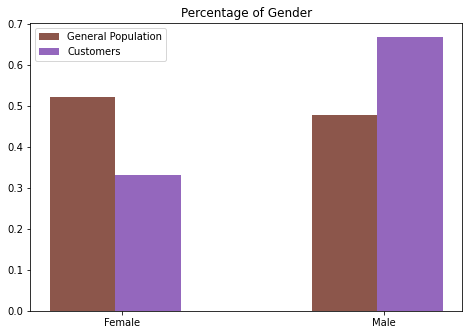

In [110]:
#Lets take a look some demographics in general population and customers
#gender 1:male 0:female

c_general = collections.Counter(azdias_clean["ANREDE_KZ"])
c_general = sorted(c_general.items())
freq_general = [i[1]/azdias_clean.shape[0] for i in c_general]

c_customer = collections.Counter(customer_clean["ANREDE_KZ"])
c_customer = sorted(c_customer.items())
freq_customer = [i[1]/customer_clean.shape[0] for i in c_customer]

X=np.arange(2)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.bar(X+0.00, freq_general,color='C5',width=0.25)
ax.bar(X+0.25, freq_customer,color='C4',width=0.25)

ax.set_xticks(X+0.15)
ax.set_xticklabels(['Female','Male'])

ax.legend(labels=['General Population','Customers'])

ax.set_title('Gender')


#### Age

In [116]:
#Age classifications
dias_attribute_values.loc[(dias_attribute_values['Attribute']=='ALTERSKATEGORIE_GROB')]


,Attribute,Description,Value,Meaning
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years
10,ALTERSKATEGORIE_GROB,NaN,9,uniformly distributed


Text(0.5, 1.0, 'Percentage of age classifications')

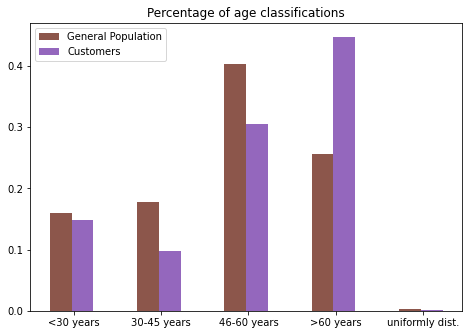

In [124]:
c_general = collections.Counter(azdias_recoded['ALTERSKATEGORIE_GROB'])
c_general = sorted(c_general.items())
freq_general = [i[1]/azdias_recoded.shape[0] for i in c_general]

c_customer = collections.Counter(customer_recoded['ALTERSKATEGORIE_GROB'])
c_customer = sorted(c_customer.items())
freq_customer = [i[1]/customer_recoded.shape[0] for i in c_customer]


X=np.arange(5)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.bar(X+0.00, freq_general,color='C5',width=0.25)
ax.bar(X+0.25, freq_customer,color='C4',width=0.25)

ax.set_xticks(X+0.15)
ax.set_xticklabels(['<30 years','30-45 years','46-60 years', '>60 years', 'uniformly dist.'])

ax.legend(labels=['General Population','Customers'])

ax.set_title('Age')

#### Social Status

In [137]:
dias_attribute_values.loc[(dias_attribute_values['Attribute']=='LP_STATUS_FEIN')]


,Attribute,Description,Value,Meaning
1966,LP_STATUS_FEIN,social status fine,1,typical low-income earners
1967,LP_STATUS_FEIN,NaN,2,orientationseeking low-income earners
1968,LP_STATUS_FEIN,NaN,3,aspiring low-income earners
1969,LP_STATUS_FEIN,NaN,4,villagers
1970,LP_STATUS_FEIN,NaN,5,minimalistic high-income earners
1971,LP_STATUS_FEIN,NaN,6,independant workers
1972,LP_STATUS_FEIN,NaN,7,title holder-households
1973,LP_STATUS_FEIN,NaN,8,new houseowners
1974,LP_STATUS_FEIN,NaN,9,houseowners
1975,LP_STATUS_FEIN,NaN,10,top earners


Text(0.5, 1.0, 'Social Status')

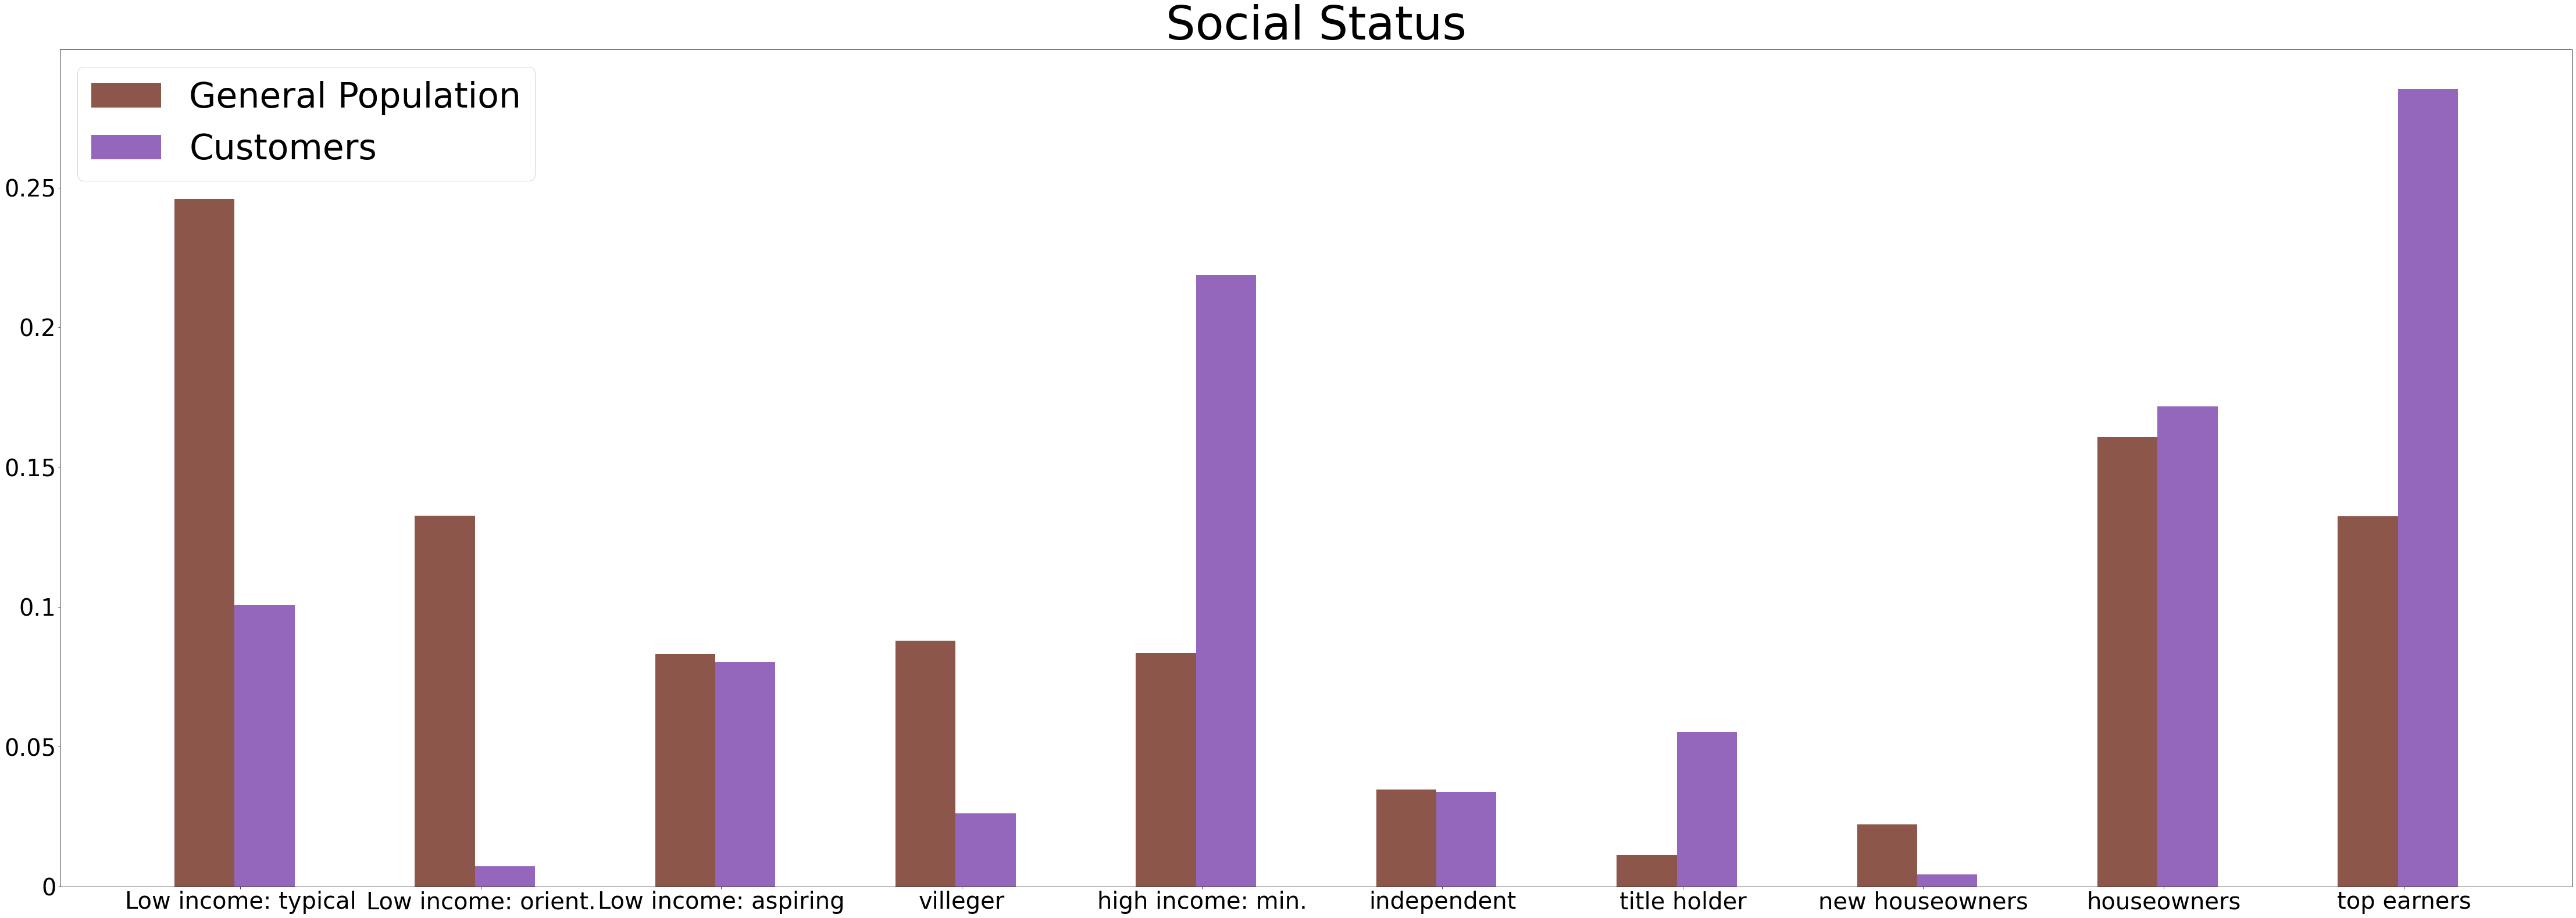

In [178]:
c_general = collections.Counter(azdias_recoded['LP_STATUS_FEIN'])
c_general = sorted(c_general.items())[0:10]
freq_general = [i[1]/azdias_recoded.shape[0] for i in c_general]

c_customer = collections.Counter(customer_recoded['LP_STATUS_FEIN'])
c_customer = sorted(c_customer.items())[0:10]
c_customer = [(1.0, 19271),(2.0, 1404), (3.0, 15364), (4.0, 5004), (5.0, 41912), (6.0, 6502), (7.0, 10574),
              (8.0, 839), (9.0, 32916),(10.0, 54653)]
freq_customer = [i[1]/customer_recoded.shape[0] for i in c_customer]


X=np.arange(10)
fig=plt.figure(figsize=(60,20))
ax=fig.add_axes([0,0,1,1])

ax.bar(X+0.00, freq_general,color='C5',width=0.25)
ax.bar(X+0.25, freq_customer,color='C4',width=0.25)

ax.set_xticks(X+0.15)
ax.set_xticklabels(['Low income: typical', 'Low income: orient.','Low income: aspiring', 'villeger', 'high income: min.',
                   'independent','title holder','new houseowners','houseowners','top earners'],fontsize=40)
ax.set_yticklabels([0,0.05,0.10,0.15,0.20,0.25],fontsize=40)
ax.legend(labels=['General Population','Customers'],fontsize=60)

ax.set_title('Social Status',fontsize=80)

#### Results of demographic comparisons
When we look the gender distribution, the prcentages of males in customers is higher than the general population while the female percentage is lower than the general population.  
The age distributions shows that the percantage of people higher that 60 years ols is quite higher in custumer population than the general population. 
Social status results shows that the percentage of high income, title owner, house owners and top earners is higher in cutomer population than the general population.

### Principle Component Analysis

In [6]:
#lets see the common columns between azdias and customer data set
common_cols=set(azdias_clean.columns).intersection(set(customer_clean.columns))

In [7]:
len(common_cols)

404

In [8]:
#Select the common columns and then do PCA
azdias_pca=azdias_clean[list(common_cols)]

In [9]:
customer_pca=customer_clean[list(common_cols)]

#### Standardize the variables

In [10]:
x_azdias = StandardScaler().fit_transform(azdias_pca)
x_azdias

array([[ 1.46506572, -0.18018299,  1.00963169, ...,  0.36544722,
        -0.35882213, -0.06531119],
       [-0.57174834, -0.18018299,  0.27147402, ...,  0.36544722,
        -0.35882213, -0.06531119],
       [-0.57174834, -0.18018299, -0.06966658, ...,  1.07217619,
         2.7868961 , -0.06531119],
       ...,
       [ 1.46506572, -0.18018299,  0.20089321, ...,  1.07217619,
        -0.35882213, -0.06531119],
       [ 1.46506572, -0.18018299, -1.42834723, ..., -1.0480107 ,
        -0.35882213, -0.06531119],
       [-0.57174834, -0.18018299,  0.31852789, ...,  1.07217619,
        -0.35882213, -0.06531119]])

In [11]:
x_customer=StandardScaler().fit_transform(customer_pca)
x_customer

array([[-0.59977526, -0.10682182,  1.56798528, ...,  0.90482001,
        -0.32591862, -0.08225757],
       [-0.59977526, -0.10682182, -0.68792766, ..., -0.47987746,
        -0.32591862, -0.08225757],
       [ 0.39869972, -0.10682182,  0.25791084, ...,  0.21247127,
        -0.32591862, -0.08225757],
       ...,
       [-0.59977526, -0.10682182, -0.07401385, ...,  0.21247127,
        -0.32591862, -0.08225757],
       [-0.59977526, -0.10682182, -1.21371987, ...,  0.90482001,
        -0.32591862, -0.08225757],
       [-0.59977526, -0.10682182,  1.40349162, ...,  0.21247127,
        -0.32591862, -0.08225757]])

#### PCA analysis

In [12]:
pca=PCA()

In [13]:
pca_fit_azdias=pca.fit(x_azdias)

In [14]:
len(pca_fit_azdias.explained_variance_ratio_)

404

In [16]:
cum_val=np.cumsum(pca_fit_azdias.explained_variance_ratio_)

Text(0, 0.5, 'Variance Explained (%)')

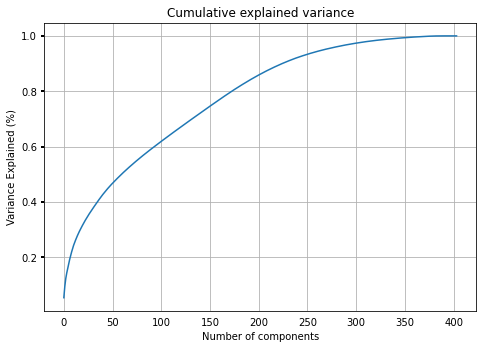

In [17]:
X=np.arange(len(pca_fit_azdias.explained_variance_ratio_))
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(X,cum_val)
ax.xaxis.set_tick_params(width=0,gridOn=True)
ax.yaxis.set_tick_params(width=2,gridOn=True)

ax.set_title('Cumulative explained variance')
ax.set_xlabel('Number of components')
ax.set_ylabel('Variance Explained (%)')

The above graph shows us 250 component explains more than 90% of the variance. I will conduct dimentionality reduction based on 250 components

#### Dimensionality reduction

In [16]:
#reperfom pca with 250 components
pca=PCA(n_components=250)
pc_azdias=pca.fit_transform(x_azdias)

In [17]:
pc_azdias

array([[ 1.47101196,  5.5139661 , -4.98326337, ..., -0.26435492,
         0.05535301, -0.24496235],
       [-1.90190228,  2.06425772, -0.07960089, ...,  0.01788214,
         0.52329974, -0.27205712],
       [-5.73322735, -0.51653826,  2.25603736, ...,  1.12220449,
        -0.01140309,  0.37397416],
       ...,
       [-2.94051658, -0.43268621, -4.85466357, ...,  0.25042061,
         0.30942993,  1.24515152],
       [ 8.13402513, -2.67238135, -6.07661853, ...,  0.41134214,
        -0.37738246,  0.3788557 ],
       [-0.40353874, -0.58689793,  2.25307089, ...,  0.05244361,
         0.75132855, -0.36498997]])

In [18]:
pc_customer=pca.fit_transform(x_customer)

In [19]:
pc_customer

array([[-2.25322401e+00, -5.14418478e+00, -3.67959801e+00, ...,
        -5.38907317e-02, -1.58605423e-01, -6.36084812e-01],
       [ 3.83697460e+00,  7.54095720e-01, -2.88524020e+00, ...,
        -2.73179356e-02,  7.84866619e-01, -5.58498639e-01],
       [-2.83235229e+00,  5.40359129e-02, -2.05622675e+00, ...,
         3.66789898e-01,  4.41334746e-03,  7.66530095e-01],
       ...,
       [-9.83033440e-01,  8.12675140e-01, -3.62404803e+00, ...,
        -6.68287740e-02, -1.72416116e-01, -1.48782570e-01],
       [ 8.52473540e-01,  4.74713624e+00, -5.87790626e-01, ...,
         1.00687804e-01, -3.53575030e-01,  4.47518795e-01],
       [-6.34145433e+00, -1.93609023e+00,  1.24956488e+00, ...,
        -8.67642219e-01, -9.68772349e-01,  7.03948903e-01]])

### Clustering based on PCA components

In [28]:
#k means clustering with different number of clusters
n_cluster= list(range(2,70,1))
c_score=[]

for cluster in range(2,70,1):
    kmean=KMeans(n_clusters=cluster , random_state=0)
    model=kmean.fit(pc_azdias)
    
    c_score.append(np.abs(model.score(pc_azdias)))

(220000000.0, 300000000.0)

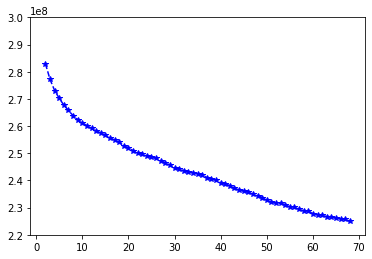

In [46]:
plt.plot(list(n_cluster),c_score,linestyle='--' ,marker='*', color='b')
plt.ylim(2.2e8, 3e8)

From the graph above, I decided to have 10 clusters

#### Distribution of clusters

In [20]:
kmean=KMeans(n_clusters=10 , random_state=0)
model=kmean.fit(pc_azdias)


In [22]:
azdias_clusters=model.predict(pc_azdias)
customer_clusters=model.predict(pc_customer)

In [28]:
cluster_prop_azdias=np.unique(azdias_clusters, return_counts=True)[1]/len(azdias_clusters)
cluster_prop_azdias

array([0.10738175, 0.12298326, 0.07398304, 0.14240556, 0.07393464,
       0.08925851, 0.10895846, 0.09445223, 0.07200769, 0.11463486])

In [29]:
cluster_prop_customer=np.unique(customer_clusters, return_counts=True)[1]/len(customer_clusters)
cluster_prop_customer

array([0.11984178, 0.13554273, 0.0887606 , 0.10735514, 0.06540517,
       0.08778419, 0.09318652, 0.07818402, 0.06551208, 0.15842777])

Text(0, 0.5, 'Percentage (%)')

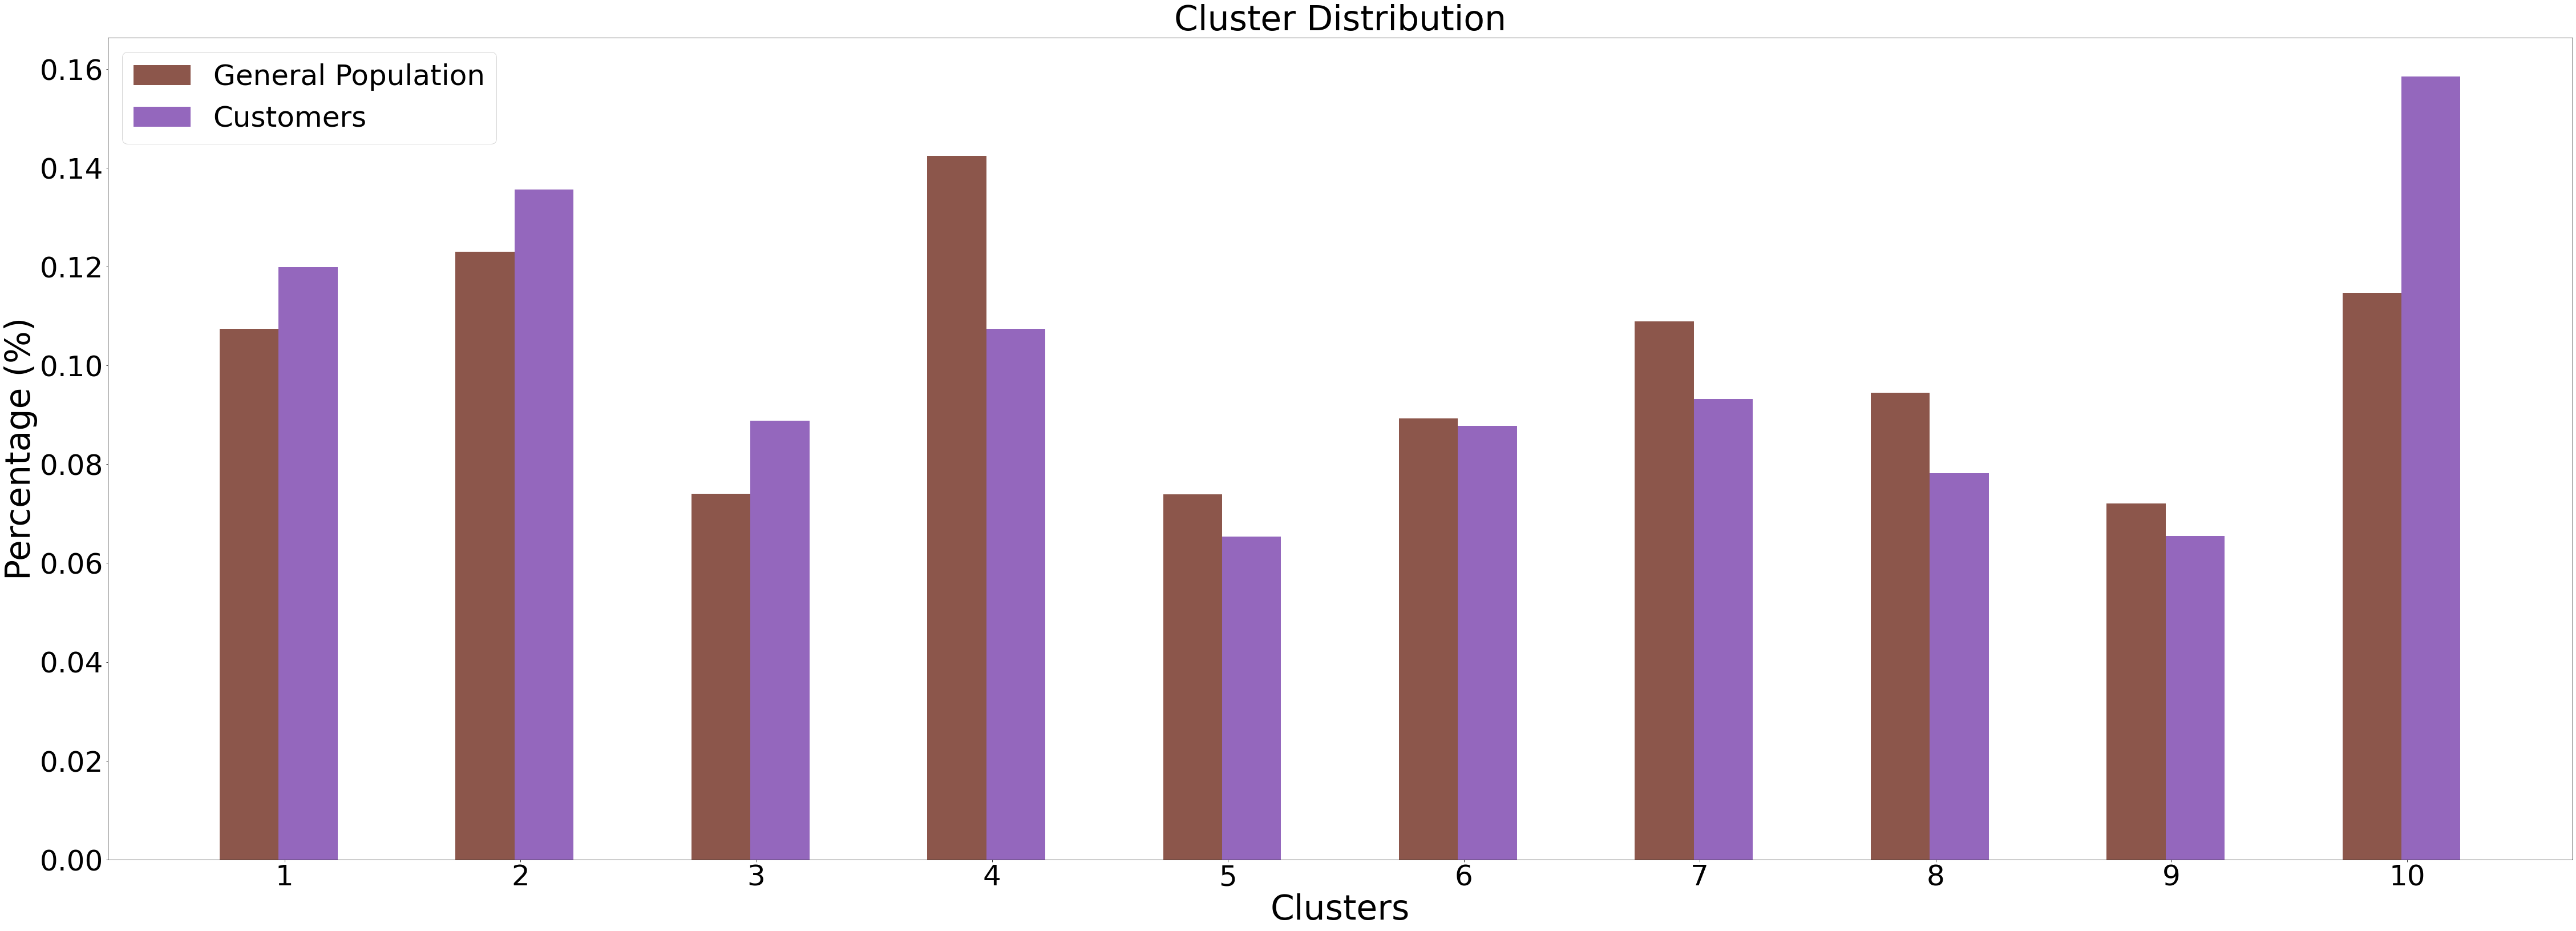

In [37]:
X=np.arange(10)
fig=plt.figure(figsize=(60,20))
ax=fig.add_axes([0,0,1,1])

ax.bar(X+0.00, cluster_prop_azdias,color='C5',width=0.25)
ax.bar(X+0.25, cluster_prop_customer,color='C4',width=0.25)

ax.set_xticks(X+0.15)
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.legend(labels=['General Population','Customers'],fontsize=50)

ax.set_title('Cluster Distribution',fontsize=60)
plt.xlabel('Clusters',fontsize=60)
plt.ylabel('Percentage (%)',fontsize=60)

When we look at the cluster distributions, the pecentage of people in clusters 1,2, and 10 is higher in the customer data. Hence, people in those clusters are more likely to become a customer

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [24]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [25]:
mailout_train.shape

(42962, 367)

#### Clean the data

In [26]:
train_clean=clean_data(mailout_train) 

recoding missing values started


C:\Users\Nermin\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


recoding missing values ended
variables having missing values more than 30% dropped
rows having missing values more than 30% dropped
missing values imputation
Recoding binary data
Dummy coding
Data cleaning ended


In [27]:
train_clean.shape

(34987, 413)

In [28]:
#getting ids in clean dataset
train_clean=train_clean.join(mailout_train[['LNR','RESPONSE']].set_index('LNR'),on='LNR',how='left',rsuffix='_other')

In [186]:
train_clean.shape

(34987, 414)

In [30]:
train_clean.head()

,KBA05_DIESEL,KBA13_SEG_KLEINWAGEN,D19_GESAMT_DATUM,KBA13_VORB_1_2,KBA13_HALTER_65,KBA05_VORB0,KBA05_ZUL1,KBA13_KW_50,KBA13_KMH_251,SEMIO_KRIT,...,REGIOTYP_6.0,REGIOTYP_7.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,RESPONSE
0,3.0,2.0,9.0,4.0,4.0,3.0,3.0,2.0,1.0,6.0,...,0,0,0,0,1,0,0,0,0,0
1,3.0,3.0,1.0,4.0,3.0,2.0,3.0,2.0,1.0,6.0,...,0,0,0,0,0,0,0,1,0,0
2,2.0,3.0,6.0,3.0,2.0,3.0,3.0,3.0,1.0,3.0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,1.0,5.0,2.0,5.0,5.0,2.0,0.0,1.0,7.0,...,0,0,1,0,0,0,0,0,0,0
4,2.0,2.0,7.0,1.0,3.0,4.0,3.0,0.0,1.0,5.0,...,0,1,0,0,1,0,0,0,0,0


#### Check the balance

In [36]:
np.unique(train_clean['RESPONSE'], return_counts=True)


(array([0, 1], dtype=int64), array([34552,   435], dtype=int64))

Text(0.5, 1.0, 'Percentage of Response')

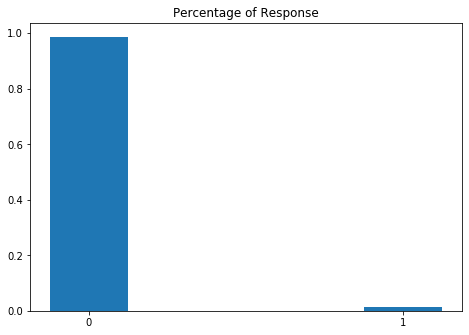

In [37]:
X=np.arange(2)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
Respose_prop_test=np.unique(train_clean['RESPONSE'], return_counts=True)[1]/train_clean.shape[0]
ax.bar(X, Respose_prop_test,color='C0',width=0.25)
ax.set_xticks(X)
ax.set_xticklabels(['0','1'])


ax.set_title('Percentage of Response')

There is an imbalance in the data set. We need to adjust our ML model accordingly

#### Get principle components

In [31]:
#scale independent variables
x_train=StandardScaler().fit_transform(train_clean.drop(['LNR','RESPONSE'],axis=1))

In [32]:
x_train

array([[ 0.97479539, -0.89865327,  1.50190991, ..., -0.25012525,
        -0.59280974, -0.1163116 ],
       [ 0.97479539,  0.06951246, -1.6421653 , ..., -0.25012525,
         1.68688187, -0.1163116 ],
       [-0.02424282,  0.06951246,  0.32288171, ..., -0.25012525,
        -0.59280974, -0.1163116 ],
       ...,
       [-0.02424282, -0.89865327,  0.32288171, ..., -0.25012525,
         1.68688187, -0.1163116 ],
       [-1.02328102,  1.03767818, -1.6421653 , ..., -0.25012525,
        -0.59280974, -0.1163116 ],
       [ 0.97479539,  0.06951246,  1.50190991, ..., -0.25012525,
         1.68688187, -0.1163116 ]])

In [33]:
x_train.shape

(34987, 412)

In [34]:
#reperfom pca with 250 components
pca=PCA(n_components=250)
pc_train=pca.fit_transform(x_train)

In [35]:
pc_train

array([[ 6.04179380e+00,  5.74149405e+00, -1.65414305e+00, ...,
         2.61867880e-01,  2.32116866e-01, -8.96430155e-01],
       [-4.91124844e+00, -4.12808734e+00, -3.25077619e-01, ...,
         2.97088635e-01,  8.74075550e-02,  1.11220828e+00],
       [ 9.65063051e-01, -1.23849065e+00, -3.33723592e+00, ...,
        -9.36731568e-02, -5.06728240e-03, -5.51481538e-01],
       ...,
       [-5.87704781e+00, -2.71351921e+00, -1.40261154e+00, ...,
        -1.23210276e-01,  3.85536245e-01, -2.57813606e-01],
       [ 2.44878990e+00, -7.89366064e-01,  1.70454209e+00, ...,
         4.66131788e-01,  4.19950596e-01, -3.73308219e-01],
       [-1.32055614e+00, -2.12703704e+00, -3.05578164e+00, ...,
        -5.43803047e-01, -7.33026142e-01,  7.37642687e-01]])

In [36]:
Y=train_clean['RESPONSE']
Y

0        0
1        0
2        0
3        0
4        0
        ..
42957    0
42958    0
42959    0
42960    0
42961    0
Name: RESPONSE, Length: 34987, dtype: int64

### FIT ML MODEL
We have an imbalance problem in our data set. There are different approacher to solve this probblem. In this code I will try following methods to select most accurate one.
* Oversampling
* Synthetic Minority Oversampling Technique (SMOTE)
* Cost-Sensitive Training (svm)
* RandomForestClassifier() 

For over spamling anf SMOTE methods i will recreate the data and use logistic regression.
For cost sentive training with svm I will balance the class weights
RandomForestClassifier is a robust method 

### Model fit with balance data through sampling

In [1]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [38]:
X_train, X_test, y_train, y_test = train_test_split(pc_train,Y, test_size=0.33, random_state=42)

##### Random Oversampling (ROS)

In [39]:
#Oversapmling
ros = RandomOverSampler(random_state=42)

#fit predictor and target variable
x_ros, y_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', np.unique(y_train, return_counts=True))
print('Resample dataset shape', np.unique(y_ros, return_counts=True))

Original dataset shape (array([0, 1], dtype=int64), array([23152,   289], dtype=int64))
Resample dataset shape (array([0, 1], dtype=int64), array([23152, 23152], dtype=int64))


###### LR with ROS

In [40]:
#Logistic regression
LR=LogisticRegression(max_iter=500)
ros_model=LR.fit(x_ros, y_ros)

In [41]:
y_pred=ros_model.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[7864, 3536],
       [  85,   61]], dtype=int64)

In [42]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5538163902907955
Accuracy score: 0.6863848952018015
F1 score: 0.03259417579481699
Balanced accuracy score: 0.5538163902907955
precision_score 0.016958576591604116
recall_score 0.4178082191780822


In [43]:
y_pred_train=ros_model.predict(x_ros)

In [44]:
LR_ros_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
LR_ros_train_score=[roc_auc_score(y_ros, y_pred_train),f1_score(y_ros,y_pred_train)]
print('LR test prediction AUC: {} F1_score: {} \nLR training prediction AUC: {} F1_score: {}'.format(LR_ros_test_score[0],
                                                                                                    LR_ros_test_score[1],
                                                                                                    LR_ros_train_score[0],
                                                                                                     LR_ros_train_score[1]))

LR test prediction AUC: 0.5538163902907955 F1_score: 0.03259417579481699 
LR training prediction AUC: 0.7340618521078093 F1_score: 0.7442256563642407


###### RFC with ROS

In [50]:
rfc = RandomForestClassifier(min_samples_split=0.3)
rfc_ros_model=rfc.fit(x_ros, y_ros)
y_pred=rfc_ros_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[8244, 3156],
       [  87,   59]], dtype=int64)

In [51]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.563633741888969
Accuracy score: 0.7191235059760956
F1 score: 0.03510859863135971
Balanced accuracy score: 0.563633741888969
precision_score 0.018351477449455676
recall_score 0.4041095890410959


In [52]:
y_pred_train=rfc_ros_model.predict(x_ros)

In [53]:
RFC_ros_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
RFC_ros_train_score=[roc_auc_score(y_ros, y_pred_train),f1_score(y_ros,y_pred_train)]
print('RFC test prediction AUC: {} F1_score: {} \nRFC training prediction AUC: {} F1_score: {}'.format(RFC_ros_test_score[0],
                                                                                                    RFC_ros_test_score[1],
                                                                                                    RFC_ros_train_score[0],
                                                                                                     RFC_ros_train_score[1]))

RFC test prediction AUC: 0.563633741888969 F1_score: 0.03510859863135971 
RFC training prediction AUC: 0.7772546648237734 F1_score: 0.7865833471279591


###### XBoost with ROS

In [54]:
model = XGBClassifier(objective='binary:logistic',eval_metric = "auc",learning_rate = 0.1,use_label_encoder=False)
XGb_ros_model=model.fit(x_ros, y_ros)
y_pred = XGb_ros_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[11384,    16],
       [  146,     0]], dtype=int64)

In [55]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.4992982456140351
Accuracy score: 0.9859691668110168
F1 score: 0.0
Balanced accuracy score: 0.4992982456140351
precision_score 0.0
recall_score 0.0


In [56]:
y_pred_train=XGb_ros_model.predict(x_ros)

In [57]:
XGb_ros_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
XGb_ros_train_score=[roc_auc_score(y_ros, y_pred_train),f1_score(y_ros,y_pred_train)]
print('XGb test prediction AUC: {} F1_score: {} \nXGb training prediction AUC: {} F1_score: {}'.format(XGb_ros_test_score[0],
                                                                                                    XGb_ros_test_score[1],
                                                                                                    XGb_ros_train_score[0],
                                                                                                    XGb_ros_train_score[1]))

XGb test prediction AUC: 0.4992982456140351 F1_score: 0.0 
XGb training prediction AUC: 0.9995680718728404 F1_score: 0.9995682583542008


##### SMOTE sampling

In [60]:
smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', np.unique(y_train, return_counts=True))
print('Resample dataset shape', np.unique(y_smote, return_counts=True))

Original dataset shape (array([0, 1], dtype=int64), array([23152,   289], dtype=int64))
Resample dataset shape (array([0, 1], dtype=int64), array([23152, 23152], dtype=int64))


##### LR with SMOTE

In [61]:
#Logistic regression
LR=LogisticRegression(max_iter=500)
LR_smote_model=LR.fit(x_smote, y_smote)
y_pred=LR_smote_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[8335, 3065],
       [  91,   55]], dtype=int64)

In [62]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5539263398221581
Accuracy score: 0.726658583059068
F1 score: 0.03368034292712799
Balanced accuracy score: 0.5539263398221581
precision_score 0.017628205128205128
recall_score 0.3767123287671233


In [63]:
y_pred_train=LR_smote_model.predict(x_smote)

In [64]:
LR_SMOTE_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
LR_SMOTE_train_score=[roc_auc_score(y_smote, y_pred_train),f1_score(y_smote,y_pred_train)]
print('LR_SMOTE test prediction AUC: {} F1_score: {} \nLR_SMOTE training prediction AUC: {} F1_score: {}'.format(LR_SMOTE_test_score[0],
                                                                                                    LR_SMOTE_test_score[1],
                                                                                                    LR_SMOTE_train_score[0],
                                                                                                    LR_SMOTE_train_score[1]))

LR_SMOTE test prediction AUC: 0.5539263398221581 F1_score: 0.03368034292712799 
LR_SMOTE training prediction AUC: 0.7791119557705598 F1_score: 0.7886689532625315


###### RFC with SMOTE

In [66]:
#Rnadom forest with smote
rfc = RandomForestClassifier(min_samples_split=0.1)
rfc_smote_model=rfc.fit(x_smote, y_smote)
y_pred=rfc_smote_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[11277,   123],
       [  141,     5]], dtype=int64)

In [81]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5089179283826004
Accuracy score: 0.9782608695652174
F1 score: 0.03088803088803089
Balanced accuracy score: 0.5089179283826004
precision_score 0.035398230088495575
recall_score 0.0273972602739726


In [82]:
y_pred_train=rfc_smote_model.predict(x_smote)

In [83]:
RFC_SMOTE_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
RFC_SMOTE_train_score=[roc_auc_score(y_smote, y_pred_train),f1_score(y_smote,y_pred_train)]
print('RFC_SMOTE test prediction AUC: {} F1_score: {} \nRFC_SMOTE training prediction AUC: {} F1_score: {}'.format(RFC_SMOTE_test_score[0],
                                                                                                    RFC_SMOTE_test_score[1],
                                                                                                    RFC_SMOTE_train_score[0],
                                                                                                    RFC_SMOTE_train_score[1]))

RFC_SMOTE test prediction AUC: 0.5089179283826004 F1_score: 0.03088803088803089 
RFC_SMOTE training prediction AUC: 0.8739633724948169 F1_score: 0.8562915538044816


###### XGboost with SMOTE

In [84]:
model = XGBClassifier(objective='binary:logistic',eval_metric = "auc",learning_rate = 0.1,use_label_encoder=False)
XGb_smote_model=model.fit(x_smote, y_smote)
y_pred = XGb_smote_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[11209,   191],
       [  141,     5]], dtype=int64)

In [85]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5087460946887767
Accuracy score: 0.9712454529707258
F1 score: 0.029239766081871347
Balanced accuracy score: 0.5087460946887767
precision_score 0.025510204081632654
recall_score 0.03424657534246575


In [86]:
y_pred_train=XGb_smote_model.predict(x_smote)

In [87]:
XGb_SMOTE_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
XGb_SMOTE_train_score=[roc_auc_score(y_smote, y_pred_train),f1_score(y_smote,y_pred_train)]
print('XGb_SMOTE test prediction AUC: {} F1_score: {} \nXGb_SMOTE training prediction AUC: {} F1_score: {}'.format(XGb_SMOTE_test_score[0],
                                                                                                    XGb_SMOTE_test_score[1],
                                                                                                    XGb_SMOTE_train_score[0],
                                                                                                    XGb_SMOTE_train_score[1]))

XGb_SMOTE test prediction AUC: 0.5087460946887767 F1_score: 0.029239766081871347 
XGb_SMOTE training prediction AUC: 0.9963502073255011 F1_score: 0.996363479870032


##### Adaptive Synthetic (ADASYN) sampling

In [74]:
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print('Original dataset shape', np.unique(y_train, return_counts=True))
print('Resample dataset shape', np.unique(y_ada, return_counts=True))

Original dataset shape (array([0, 1], dtype=int64), array([23152,   289], dtype=int64))
Resample dataset shape (array([0, 1], dtype=int64), array([23152, 23089], dtype=int64))


##### LR with ADASYN

In [75]:
LR=LogisticRegression(max_iter=500)
LR_ADA_model=LR.fit(X_ada, y_ada)
y_pred=LR_ADA_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[8310, 3090],
       [  90,   56]], dtype=int64)

In [76]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5562545061283344
Accuracy score: 0.7245799411051447
F1 score: 0.034021871202916165
Balanced accuracy score: 0.5562545061283346
precision_score 0.017800381436745075
recall_score 0.3835616438356164


In [77]:
y_pred_train=LR_ADA_model.predict(X_ada)

In [78]:
LR_ADA_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
LR_ADA_train_score=[roc_auc_score(y_ada, y_pred_train),f1_score(y_ada,y_pred_train)]
print('LR_ADA test prediction AUC: {} F1_score: {} \nLR_ADA training prediction AUC: {} F1_score: {}'.format(LR_ADA_test_score[0],
                                                                                                    LR_ADA_test_score[1],
                                                                                                    LR_ADA_train_score[0],
                                                                                                    LR_ADA_train_score[1]))

LR_ADA test prediction AUC: 0.5562545061283344 F1_score: 0.034021871202916165 
LR_ADA training prediction AUC: 0.7756477748972509 F1_score: 0.78468720821662


###### RFC with ADASYN

In [80]:
#Random forest with smote
rfc = RandomForestClassifier(min_samples_split=0.1)
rfc_ada_model=rfc.fit(X_ada, y_ada)
y_pred=rfc_ada_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[11291,   109],
       [  142,     4]], dtype=int64)

In [89]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5089179283826004
Accuracy score: 0.9782608695652174
F1 score: 0.03088803088803089
Balanced accuracy score: 0.5089179283826004
precision_score 0.035398230088495575
recall_score 0.0273972602739726


In [90]:
y_pred_train=rfc_ada_model.predict(X_ada)

In [91]:
RFC_ADA_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
RFC_ADA_train_score=[roc_auc_score(y_ada, y_pred_train),f1_score(y_ada,y_pred_train)]
print('RFC_ADA test prediction AUC: {} F1_score: {} \nRFC_ADA training prediction AUC: {} F1_score: {}'.format(RFC_ADA_test_score[0],
                                                                                                    RFC_ADA_test_score[1],
                                                                                                    RFC_ADA_train_score[0],
                                                                                                    RFC_ADA_train_score[1]))

RFC_ADA test prediction AUC: 0.5089179283826004 F1_score: 0.03088803088803089 
RFC_ADA training prediction AUC: 0.871545510337496 F1_score: 0.8532191814717672


##### XGboost with ADASYN

In [92]:
model = XGBClassifier(objective='binary:logistic',eval_metric = "auc",learning_rate = 0.1,use_label_encoder=False)
XGb_ADA_model=model.fit(X_ada, y_ada)
y_pred = XGb_ADA_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[11219,   181],
       [  140,     6]], dtype=int64)

In [93]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5126093487142513
Accuracy score: 0.972198163866274
F1 score: 0.036036036036036036
Balanced accuracy score: 0.5126093487142513
precision_score 0.03208556149732621
recall_score 0.0410958904109589


In [94]:
y_pred_train=XGb_ADA_model.predict(X_ada)

In [95]:
XGb_ADA_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
XGb_ADA_train_score=[roc_auc_score(y_ada, y_pred_train),f1_score(y_ada,y_pred_train)]
print('XGb_ADA test prediction AUC: {} F1_score: {} \nXGb_ADA training prediction AUC: {} F1_score: {}'.format(XGb_ADA_test_score[0],
                                                                                                    XGb_ADA_test_score[1],
                                                                                                    XGb_ADA_train_score[0],
                                                                                                    XGb_ADA_train_score[1]))

XGb_ADA test prediction AUC: 0.5126093487142513 F1_score: 0.036036036036036036 
XGb_ADA training prediction AUC: 0.9963070145127851 F1_score: 0.9963106000129451


### Model fit with imbalanced data

##### LR with balanced class weights

In [96]:
LR_balanced=LogisticRegression(solver='newton-cg',class_weight='balanced', max_iter=1000)

In [97]:
LR_model=LR_balanced.fit(X_train, y_train)
y_pred=LR_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7849, 3551],
       [  84,   62]], dtype=int64)

In [98]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5565831530882
Accuracy score: 0.6851723540620128
F1 score: 0.03298749667464751
Balanced accuracy score: 0.5565831530882
precision_score 0.017160254636036536
recall_score 0.4246575342465753


In [99]:
y_pred_train=LR_model.predict(X_train)

In [100]:
LR_imb_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
LR_imb_train_score=[roc_auc_score(y_train, y_pred_train),f1_score(y_train,y_pred_train)]
print('LR_imb test prediction AUC: {} F1_score: {} \nLR_imb training prediction AUC: {} F1_score: {}'.format(LR_imb_test_score[0],
                                                                                                    LR_imb_test_score[1],
                                                                                                    LR_imb_train_score[0],
                                                                                                    LR_imb_train_score[1]))

LR_imb test prediction AUC: 0.5565831530882 F1_score: 0.03298749667464751 
LR_imb training prediction AUC: 0.7285217386885645 F1_score: 0.05790645879732739


Sampling methods seems to work better than balanced LR

##### RFC with imbalanced data

In [103]:
rfc = RandomForestClassifier(class_weight='balanced')

# fit the predictor and target
rfc_model=rfc.fit(X_train, y_train)
y_pred=rfc_model.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[11400,     0],
       [  146,     0]], dtype=int64)

In [107]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
#searching best parameters

In [192]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))


ROCAUC score: 0.51531663061764
Accuracy score: 0.8373462671054911
F1 score: 0.027950310559006212
Balanced accuracy score: 0.51531663061764
precision_score 0.015117581187010079
recall_score 0.18493150684931506


In [188]:
y_pred_train=rfc_model.predict(X_train)

In [189]:
RFC_imb_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
RFC_imb_train_score=[roc_auc_score(y_train, y_pred_train),f1_score(y_train,y_pred_train)]
print('LR_imb test prediction AUC: {} F1_score: {} \nLR_imb training prediction AUC: {} F1_score: {}'.format(RFC_imb_test_score[0],
                                                                                                    RFC_imb_test_score[1],
                                                                                                    RFC_imb_train_score[0],
                                                                                                    RFC_imb_train_score[1]))

LR_imb test prediction AUC: 0.5121335015621246 F1_score: 0.027567195037904894 
LR_imb training prediction AUC: 0.7708581679551775 F1_score: 0.1255006675567423


##### XGboost with imbalanced data

In [113]:
model = XGBClassifier(objective='binary:logistic',eval_metric = "auc",use_label_encoder=False,scale_pos_weight=100)
XGb_model=model.fit(X_train, y_train)
y_pred = XGb_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[11400,     0],
       [  146,     0]], dtype=int64)

In [194]:
#scale_pos_weight = total_negative_examples / total_positive_examples
np.unique(y_train, return_counts=True) #you can get number of people with this line
scale_pos_weight=123152/289
scale_pos_weight

426.13148788927333

In [213]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Balanced accuracy score:',balanced_accuracy_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))

ROCAUC score: 0.5136157173756308
Accuracy score: 0.1663779663952884
F1 score: 0.025711104362789755
Balanced accuracy score: 0.5136157173756308
precision_score 0.013048392068221514
recall_score 0.8698630136986302


In [214]:
XGb_imb_test_score=[roc_auc_score(y_test, y_pred),f1_score(y_test, y_pred)]
XGb_imb_train_score=[roc_auc_score(y_train, y_pred_train),f1_score(y_train,y_pred_train)]
print('LR_imb test prediction AUC: {} F1_score: {} \nLR_imb training prediction AUC: {} F1_score: {}'.format(XGb_imb_test_score[0],
                                                                                                    XGb_imb_test_score[1],
                                                                                                    XGb_imb_train_score[0],
                                                                                                    XGb_imb_train_score[1]))

LR_imb test prediction AUC: 0.5136157173756308 F1_score: 0.025711104362789755 
LR_imb training prediction AUC: 0.7708581679551775 F1_score: 0.1255006675567423


#### Summary and Model Selection
In general results showed that sampling methods outperforms the cost sensitive training. This part summarizes the AUC results for training and testing data for all models has run above

In [274]:
ros_test=[LR_ros_test_score[0],RFC_ros_test_score[0],XGb_ros_test_score[0]]
ros_train=[LR_ros_train_score[0],RFC_ros_train_score[0],XGb_ros_train_score[0]]
smote_test=[LR_SMOTE_test_score[0],RFC_SMOTE_test_score[0],XGb_SMOTE_test_score[0]]
smote_train=[LR_SMOTE_train_score[0],RFC_SMOTE_train_score[0],XGb_SMOTE_train_score[0]]
adasyn_test=[LR_ADA_test_score[0],RFC_ADA_test_score[0],XGb_ADA_test_score[0]]
adasyn_train=[LR_ADA_train_score[0],RFC_ADA_train_score[0],XGb_ADA_train_score[0]]
imbalance_test= [LR_imb_test_score[0],RFC_imb_test_score[0],XGb_imb_test_score[0]]
imbalance_train=[LR_imb_train_score[0],RFC_imb_train_score[0],XGb_imb_train_score[0]]

In [275]:
adasyn_test

[0.7483527064827584, 0.8587979740583814, 0.9870438923797229]

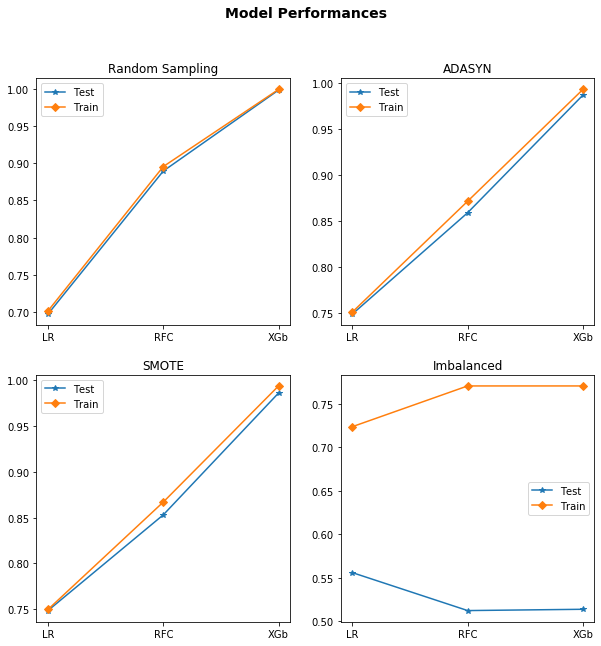

In [276]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))

fig.subplots_adjust(wspace=0.2, hspace=0.2)

fig.suptitle('Model Performances',fontweight='bold',fontsize=14)

X = ['LR','RFC','XGb']


axs[0,0].plot(X,ros_test,color ='C0',marker='*')
axs[0,0].plot(X,ros_train,color ='C1',marker='D')

axs[1,0].plot(X,smote_test,color ='C0',marker='*')
axs[1,0].plot(X,smote_train,color ='C1',marker='D')

axs[0,1].plot(X,adasyn_test,color ='C0',marker='*')
axs[0,1].plot(X,adasyn_train,color ='C1',marker='D')

axs[1,1].plot(X,imbalance_test,color ='C0',marker='*')
axs[1,1].plot(X,imbalance_train,color ='C1',marker='D')

axs[0,0].set_title('Random Sampling')
axs[1,0].set_title('SMOTE')
axs[0,1].set_title('ADASYN')
axs[1,1].set_title('Imbalanced')

ax.set_xticklabels(['LR','RFC','XGb'])
axs[0,0].legend(labels=['Test','Train'])
axs[1,0].legend(labels=['Test','Train'])
axs[0,1].legend(labels=['Test','Train'])
axs[1,1].legend(labels=['Test','Train'])

plt.show()

The results shows that sampling methods fits better than the imbalance data. Between the models, XGboost seems to provide better fit. For this reason we will continue to work with SMOTE sampling and XGboost  method.

NameError: name 'ax' is not defined

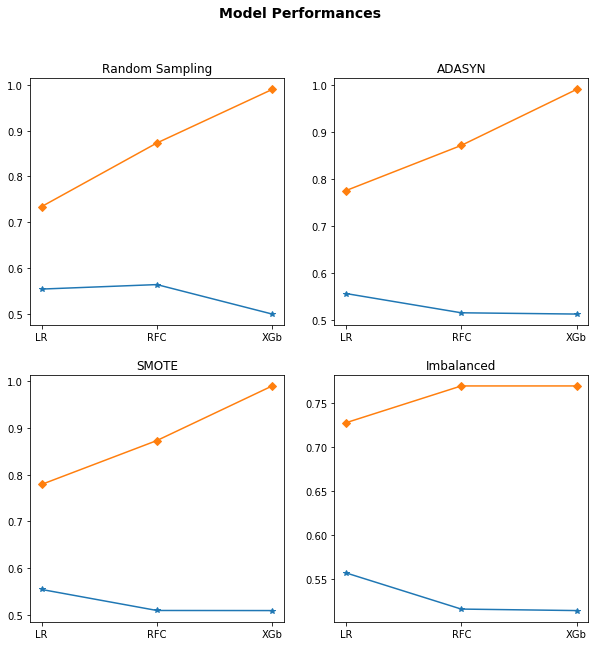

In [6]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))

fig.subplots_adjust(wspace=0.2, hspace=0.2)

fig.suptitle('Model Performances',fontweight='bold',fontsize=14)

X = ['LR','RFC','XGb']


axs[0,0].plot(X,[0.5538,0.5636,0.4992],color ='C0',marker='*')
axs[0,0].plot(X,[0.734,0.873,0.99],color ='C1',marker='D')

axs[1,0].plot(X,[0.5539,0.5089,0.5087],color ='C0',marker='*')
axs[1,0].plot(X,[0.779,0.873,0.99],color ='C1',marker='D')

axs[0,1].plot(X,[0.5562,0.5153,0.5126],color ='C0',marker='*')
axs[0,1].plot(X,[0.775,0.871,0.99],color ='C1',marker='D')

axs[1,1].plot(X,[0.5566,0.5153,0.5136],color ='C0',marker='*')
axs[1,1].plot(X,[0.728,0.77,0.77],color ='C1',marker='D')

axs[0,0].set_title('Random Sampling')
axs[1,0].set_title('SMOTE')
axs[0,1].set_title('ADASYN')
axs[1,1].set_title('Imbalanced')

ax.set_xticklabels(['LR','RFC','XGb'])
axs[0,0].legend(labels=['Test','Train'])
axs[1,0].legend(labels=['Test','Train'])
axs[0,1].legend(labels=['Test','Train'])
axs[1,1].legend(labels=['Test','Train'])

plt.show()

##### Grid Search

###### RFC

In [108]:
param_grid = {'min_samples_leaf':[3,5,7,10,15],'max_features':[0.5,'sqrt','log2'],
          'max_depth':[10,15,20],
          'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:5},'balanced'],
          'criterion':['entropy','gini']}

sss = StratifiedShuffleSplit(n_splits=5)
grid = GridSearchCV(RandomForestClassifier(),param_grid,cv=sss,verbose=1,n_jobs=-1,scoring='roc_auc')
grid.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 86.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 191.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 366.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 555.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 737.3min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 738.3min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 5}, 'balanced'],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 15, 20],
                         'max_features': [0.5, 'sqrt', 'log2'],
                         'min_samples_leaf': [3, 5, 7, 10, 15]},
             scoring='roc_auc', verbose=1)

In [109]:
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 10}

In [110]:
grid.best_score_

0.601048180572926

###### XGboost

In [114]:
Xgb = XGBClassifier(objective='binary:logistic',use_label_encoder=False)

In [119]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'scale_pos_weight':range(1,10,2),
 'learning_rate' :[0.05,0.1,0.2]
}
gsearch1 = GridSearchCV(estimator = Xgb, param_grid = param_test1, 
                        scoring='roc_auc',n_jobs=4,iid=False, cv=sss)
gsearch1.fit(X_train, y_train)


C:\Users\Nermin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[16:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, us

In [120]:
gsearch1.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'scale_pos_weight': 3}

In [121]:
 gsearch1.best_score_

0.5765631953150637

### Final Model

In [125]:
Final_model=RandomForestClassifier(class_weight= 'balanced', criterion= 'entropy',max_depth= 10, max_features= 'sqrt',
                       min_samples_leaf= 10)

In [ ]:
#train the model with the whole training data
Final_model.fit(X_train, y_train)
y_pred = Final_model.predict(X_test)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [138]:
mailout_test=pd.read_csv('test.csv')

C:\Users\Nermin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [139]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [70]:
mailout_test.shape

(42833, 366)

In [140]:
clean_test=clean_data(mailout_test) 

recoding missing values started


C:\Users\Nermin\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


recoding missing values ended
variables having missing values more than 30% dropped
rows having missing values more than 30% dropped
missing values imputation
Recoding binary data
Dummy coding
Data cleaning ended


In [141]:
clean_test.shape

(34980, 413)

In [107]:
clean_test.columns

Index(['KBA13_OPEL', 'KBA13_VORB_1_2', 'PLZ8_ANTG2', 'KBA13_KRSSEG_KLEIN',
       'ONLINE_AFFINITAET', 'KBA05_SEG4', 'KBA05_KRSAQUOT', 'KBA13_HALTER_40',
       'KBA13_SEG_OBERKLASSE', 'KBA05_CCM2',
       ...
       'REGIOTYP_5.0', 'REGIOTYP_6.0', 'REGIOTYP_7.0', 'WOHNLAGE_1.0',
       'WOHNLAGE_2.0', 'WOHNLAGE_3.0', 'WOHNLAGE_4.0', 'WOHNLAGE_5.0',
       'WOHNLAGE_7.0', 'WOHNLAGE_8.0'],
      dtype='object', length=413)

In [142]:
#Check the columns in the test and train data
Drop_col=[]
c=0
for column in list(clean_test.columns):
    if column in list(train_clean.columns):
        c+=1
    else:
        Drop_col.append(column)
print(' Number of common columns: {}\n Number of noncommon columns : {}'.format(c,len(Drop_col)))  

 Number of common columns: 413
 Number of noncommon columns : 0


In [143]:
#standardize the variables
x_test=StandardScaler().fit_transform(clean_test.drop(['LNR'],axis=1))

In [144]:
x_test

array([[-0.01285069,  0.08024857, -0.45577151, ..., -0.24872939,
        -0.60209712, -0.11795356],
       [-0.01285069, -1.86036316,  1.51511405, ...,  4.02043358,
        -0.60209712, -0.11795356],
       [ 0.98386107, -0.8900573 , -0.0615944 , ..., -0.24872939,
        -0.60209712, -0.11795356],
       ...,
       [-0.01285069,  0.08024857, -0.0615944 , ..., -0.24872939,
        -0.60209712, -0.11795356],
       [-0.01285069,  0.08024857,  0.33258271, ..., -0.24872939,
        -0.60209712, -0.11795356],
       [ 0.98386107,  0.08024857, -0.45577151, ..., -0.24872939,
        -0.60209712, -0.11795356]])

In [145]:
#calculate principle components
pca=PCA(n_components=250)
pc_test=pca.fit_transform(x_test)

In [146]:
pc_test

array([[-4.64396490e+00,  6.94117880e+00, -3.02347134e+00, ...,
        -7.68758154e-01, -6.08928834e-01,  5.01426479e-01],
       [ 2.54802241e+00,  2.70393774e+00,  9.88254973e-01, ...,
         4.52845772e-01,  9.69729063e-02, -2.25868988e-01],
       [-1.46546841e+00,  3.27393152e+00, -2.81294074e+00, ...,
        -7.34371846e-01,  5.04469592e-01,  9.55954313e-01],
       ...,
       [-6.05643523e+00, -6.70476227e-03,  3.29140985e+00, ...,
         2.46589661e-01, -5.11241915e-01, -3.60428692e-01],
       [ 1.84069520e-01, -2.10108716e+00,  2.33159833e+00, ...,
        -2.14783418e+00, -2.96372798e-01, -1.62764161e-01],
       [ 1.62620579e+00,  8.80518241e-01,  5.53936864e+00, ...,
         1.40595464e+00, -1.41727656e-01, -4.60600136e-01]])

In [133]:
Final_model=RandomForestClassifier(class_weight= 'balanced', criterion= 'entropy',max_depth= 10, max_features= 'sqrt',
                       min_samples_leaf= 10)

In [153]:
Final_model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='sqrt', min_samples_leaf=10)

In [154]:
y_test_pred = Final_model.predict(pc_test)

In [185]:
np.unique(y_test_pred, return_counts=True)

(array([0, 1]), array([34833,   147], dtype=int64))

In [163]:
result=pd.DataFrame({'LNR':clean_test['LNR'],'RESPONSE':y_test_pred})

In [164]:
result.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [95]:
result.shape

(34980, 2)

In [112]:
mailout_test.shape[0]-result.shape[0]

7853

There are 7853 people that we dropped from the data as they have more than 30% missing data. But we still need to classify them


In [166]:
remaining_test=list(set(mailout_test['LNR']).difference(set(result['LNR'])))

In [167]:
len(remaining_test)

7853

In [168]:
temp=mailout_test.set_index('LNR')

In [169]:
remainin_df=temp.loc[remaining_test]

In [170]:
remainin_df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,2
3,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
4,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
6,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1
7,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3


In [171]:
#recode missing
remaning_recoded=recode_missing(remainin_df)
remaning_recoded.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0


In [172]:
#check the missing rate in each row
row_nan_remaning = remaning_recoded.isnull().sum(axis=1)/len(remaning_recoded.columns)
sorted_nan_remaning_row=np.sort(row_nan_remaning.values)[::-1]

column_nan_remaning = remaning_recoded.isnull().sum(axis=0)/len(remaning_recoded.index)
sorted_nan_remaning_column=np.sort(column_nan_remaning.values)[::-1]

In [173]:
sorted_nan_remaning_row[0:10]

array([0.78356164, 0.76986301, 0.76986301, 0.76986301, 0.76986301,
       0.76986301, 0.76986301, 0.76986301, 0.76986301, 0.76986301])

In [174]:
sorted_nan_remaning_column[0:10]

array([1.        , 0.99961798, 0.99847192, 0.99847192, 0.99847192,
       0.99847192, 0.99847192, 0.99847192, 0.99847192, 0.99847192])

Text(400, 0.3, 'Mean: 0.7512026640198579')

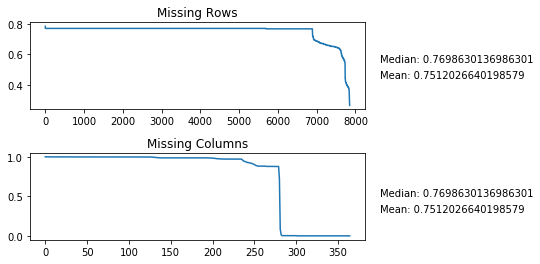

In [175]:
fig, axs = plt.subplots(2)
fig.subplots_adjust(wspace=0.5, hspace=0.5)

axs[0].plot(sorted_nan_remaning_row)
axs[1].plot(sorted_nan_remaning_column)

axs[1].set_title('Missing Columns')
axs[0].set_title('Missing Rows')

plt.text(400, 2.2, s='Median: {}'.format(np.median(sorted_nan_remaning_row)))
plt.text(400, 2, s='Mean: {}'.format(np.mean(sorted_nan_remaning_row)))

plt.text(400, 0.5, s='Median: {}'.format(np.median(sorted_nan_remaning_row)))
plt.text(400, 0.3, s='Mean: {}'.format(np.mean(sorted_nan_remaning_row)))

In [176]:
remaning_clean=remaning_recoded.dropna(axis=1,how='any')
remaning_clean.shape

(7853, 64)

In [177]:
remaning_clean.columns

Index(['D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK',
       'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_REST', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT',
       'D19_WEIN_FEINKOST', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_VORSORGER', 'FINANZTYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE',
       'KOMBIALTER', 'SEMIO_DO

##### Approach I: Customer segmentation

In [222]:
azdias2=azdias_recoded[list(remaning_clean.columns)]

In [223]:
azdias2.shape

(891221, 64)

In [ ]:
customer2=customer_recoded[remaning_clean.columns]
customer2.shape

In [169]:
#k means clustering with different number of clusters
n_cluster= list(range(2,70,1))
c_score=[]

for cluster in range(2,70,1):
    kmean=KMeans(n_clusters=cluster , random_state=0)
    model=kmean.fit(azdias2)
    
    c_score.append(np.abs(model.score(azdias2)))

In [174]:
n_cluster= list(range(2,70,1))

In [175]:
len(n_cluster)

68

In [173]:
len(c_score)

68

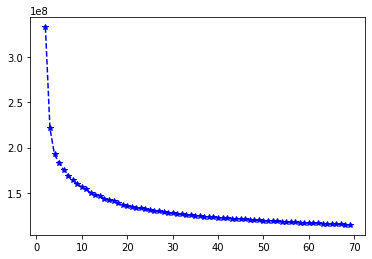

In [176]:
plt.plot(list(n_cluster),c_score,linestyle='--' ,marker='*', color='b')

In [225]:
kmean=KMeans(n_clusters=6, random_state=0)
model=kmean.fit(azdias2)

In [178]:
azdias2_clusters=model.predict(azdias2)
customer2_clusters=model.predict(customer2)
remaning_clusters=model.predict(remaning_clean)

In [179]:
cluster_prop_azdias2=np.unique(azdias2_clusters, return_counts=True)[1]/len(azdias2_clusters)
cluster_prop_azdias2

array([0.14185707, 0.23221289, 0.15289137, 0.08841241, 0.17663632,
       0.20798994])

In [180]:
cluster_prop_customer2=np.unique(customer2_clusters, return_counts=True)[1]/len(customer2_clusters)
cluster_prop_customer2

array([0.01390541, 0.24902949, 0.17358024, 0.2552491 , 0.0718855 ,
       0.23635026])

In [182]:
cluster_prop_remaning=np.unique(remaning_clusters, return_counts=True)[1]/len(remaning_clusters)
cluster_prop_remaning

array([0.00178276, 0.87953648, 0.02826945, 0.0427862 , 0.01018719,
       0.03743792])

Text(0, 0.5, 'Percentage (%)')

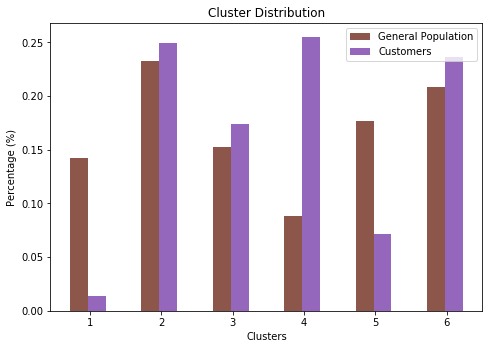

In [190]:
X=np.arange(6)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

ax.bar(X+0.00, cluster_prop_azdias2,color='C5',width=0.25)
ax.bar(X+0.25, cluster_prop_customer2,color='C4',width=0.25)

ax.set_xticks(X+0.15)
ax.set_xticklabels([1,2,3,4,5,6])
ax.tick_params(axis='both', which='major')
ax.legend(labels=['General Population','Customers'])

ax.set_title('Cluster Distribution')
plt.xlabel('Clusters')
plt.ylabel('Percentage (%)')

In [224]:
cluster_prop_customer2/(cluster_prop_azdias2+cluster_prop_customer2)

array([0.08927318, 0.51747207, 0.53168556, 0.74273402, 0.28925227,
       0.53191285])

Customer segmentation for this part showed that cluster 4 and cluster 6 is more linely to be customers. Hence in the remaining group, We assign people in the culster 4 and 6 to 1 as response and zero for the remaining ones.

In [228]:
temp=pd.DataFrame({'LNR': remaning_clean.index,'RESPONSE': remaning_clusters})
temp.head()

,LNR,RESPONSE
0,2,1
1,3,1
2,4,1
3,6,1
4,7,1


In [229]:
temp.loc[(temp['RESPONSE']==1)|(temp['RESPONSE']==2) |(temp['RESPONSE']==3)|(temp['RESPONSE']==5),'RESPONSE']=0
temp.loc[(temp['RESPONSE']==4)|(temp['RESPONSE']==6),'RESPONSE']=1
temp.head()

,LNR,RESPONSE
0,2,0
1,3,0
2,4,0
3,6,0
4,7,0


In [230]:
final_results=pd.concat([result,temp])
final_results.shape

(42833, 2)

##### Approach 2: putting another ml model for remaining part

In [205]:
remaining_cols=list(set(train_clean.columns).intersection(set(remaning_clean.columns)))


In [206]:
train2=train_clean[list(remaining_cols)]
train2.head()

,SEMIO_FAM,ALTERSKATEGORIE_GROB,SEMIO_VERT,SEMIO_LUST,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,SEMIO_KRIT,SEMIO_DOM,FINANZ_VORSORGER,SEMIO_KULT,...,SEMIO_ERL,FINANZTYP,SEMIO_RAT,FINANZ_SPARER,SEMIO_SOZ,FINANZ_ANLEGER,SEMIO_PFLICHT,SEMIO_MAT,SEMIO_KAEM,ANREDE_KZ
0,2.0,4.0,3.0,7.0,1.0,1.0,6.0,6.0,5.0,1.0,...,7.0,6.0,2.0,1.0,5.0,2.0,3.0,1.0,6.0,0.0
1,1.0,3.0,4.0,6.0,1.0,3.0,6.0,6.0,5.0,3.0,...,6.0,6.0,4.0,1.0,1.0,2.0,5.0,5.0,5.0,0.0
2,4.0,4.0,7.0,7.0,1.0,1.0,3.0,3.0,4.0,4.0,...,3.0,5.0,1.0,1.0,3.0,1.0,1.0,6.0,1.0,1.0
3,1.0,4.0,2.0,7.0,2.0,3.0,7.0,5.0,5.0,1.0,...,7.0,5.0,2.0,1.0,5.0,1.0,4.0,1.0,6.0,0.0
4,6.0,3.0,7.0,6.0,1.0,2.0,5.0,5.0,5.0,5.0,...,4.0,5.0,5.0,1.0,6.0,1.0,4.0,6.0,2.0,1.0


In [208]:
x_TRAIN2=StandardScaler().fit_transform(train2)

In [209]:
x_TRAIN2.shape

(34987, 25)

In [210]:
Xgb.fit(x_TRAIN2,Y)

[20:57:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [215]:
remaning_clean_std=StandardScaler().fit_transform(remaning_clean[list(remaining_cols)])

In [217]:
remaning_clean_std.shape

(7853, 25)

In [218]:
remaining_response=Xgb.predict(remaning_clean_std)

In [219]:
np.unique(remaining_response, return_counts=True)

(array([0, 1]), array([7852,    1], dtype=int64))

In [231]:
final_results.to_csv('NKUysal.csv', index = False, header=True)